# Let's find the differential distribution of MACs across organs across time
- Let's take the Macrophage score and count number of cells enriched with this module (>0 Z-score)

#### This follows from: 
- LR across cross organ integration
- SCVI integegration of just MAC lineage
- SCVI DEGs of Pre-AGM YS macs vs all macs post AGM
- Top markers used to create a functional score


#### Relabel YS macrophages acording to Pan-fetal annotations
- YS macs should be iron recyling and LYVE1 high

In [8]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, color_map='viridis')
plt.rcParams['figure.figsize'] = [8, 8]

In [9]:
# variables module

models = {
'pan_fetal':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/adifa_lr/celltypist_model.Pan_Fetal_Human.pkl',
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'adata_scvi':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/scvi_low_dim_model.sav',
'adata_ldvae':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/ldvae_low_dim_model.sav',
'adata_harmony':'/nfs/team205/ig7/work_backups/backup_210306/projects/amiotic_fluid/train_low_dim_model/organ_low_dim_model.sav',
'test_low_dim_ipsc_ys':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/lr_model.sav',
'YS_X':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/YS_X_model_080922.sav'
}
adatas_dict = {
'amnion':'/nfs/team205/ig7/work_backups/backup_210306/projects/amiotic_fluid/data/from_max/v1_a1_amnion.h5ad',
'adata_scvi':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/scvi_model_landscape_low_dim.h5ad',
'adata_ldvae':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/ldvae_model_landscape_low_dim.h5ad',
'adata_harmony':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/data/model_landscape_low_dim.h5ad',
'fliv_wget_test':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'test_low_dim_ys':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/YS_vt_HM_YS_LR_normalised_umap.h5ad',
'matched_EL':'//lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/A4_V8_Eliver_raw_updated_metadata_20220523.h5ad',
'YS_citeseq':'/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/ys_citeseq_rna_raw_20220701.h5ad',
'gonads':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Gonads/A1_V1_gonads_LR_panf_ys.h5ad',
'YS_X':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V9_scvi_YS_integrated/A2_V9_scvi_V8_model_selected_raw_qc_scr_umap.h5ad',
'scvi_V8_all_myeloid':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/SCVi_mac_integration_degs/macs_panf_ys_brain_eliv/A1_V8_scvi_YS_macs_updated_panf_gonads_brain_build_donor_organ_corrected_120922.h5ad',
'scvi_V9_all_myeloid':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/SCVi_mac_integration_degs/macs_panf_ys_brain_eliv/A1_V9_scvi_YS_macs_updated_panf_gonads_brain_build_donor_organ_corrected_120922.h5ad',
'scvi_V10_all_myeloid':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/SCVi_mac_integration_degs/macs_panf_ys_brain_eliv/A1_V10_scvi_YS_macs_updated_panf_gonads_brain_build_donor_organ_corrected_120922.h5ad',
}

# Variable assignment
adata_key = 'scvi_V10_all_myeloid'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
train_x_partition = 'X' # what partition was the data trained on? To keep simple, for now only accepts 'X'
dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'cell_labels_lvl2'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented

# Partial scaling ver
- scale across 10 mini bulks/every 100,000 cells
- sequential learning for scaling
- sequential application of scaling

In [3]:
adatas_dict = {'fliv_wget_test':'https://app.cellatlas.io/fetal-liver/dataset/1/download',}
adata_key = 'fliv_wget_test'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)

def load_adatas(adatas_dict,data_merge, data_key_use):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
                adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            adatas[dataset] = sc.read(data[dataset])
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            adata = sc.read(adatas_dict[data_key_use])
        del adata.uns
        del adata.obsp
        return adata

In [4]:
def load_models(model_dict,model_run):
    if (Path(model_dict[model_run])).is_file():
        # Load data (deserialize)
        model = pkl.load(open(model_dict[model_run], "rb"))
        return model
    elif 'https' in model_dict[model_run]:
        print('Loading model from web source')
        r_get = requests.get(model_dict[model_run])
        fpath = './model_temp.sav'
        open(fpath , 'wb').write(r_get.content)
        model = pkl.load(open(fpath, "rb"))
        return model

def load_adatas(adatas_dict,data_merge, data_key_use):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
                adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            adatas[dataset] = sc.read(data[dataset])
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            adata = sc.read(adatas_dict[data_key_use])
        del adata.uns
        del adata.obsp
        return adata

In [13]:
# adata =  load_adatas(adatas_dict, data_merge, adata_key)
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/macs_panf_ys_brain_eliv/A2_V2_MACs_pan_organ_scvi_241122.h5ad')
adata = adata[~adata.obs['LVL3'].isin(['MONOCYTE_MACROPHAGE'])]

In [30]:
adata_osteo = adata_2[adata_2.obs['LVL3'].isin(['OSTEOCLAST'])].to_memory()

In [ ]:
# obsm = (adata[adata.obs['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])].obsm['X_umap'][0:len(adata_osteo.obs)])
# adata_osteo.obsm['X_umap'] = obsm
# adata = adata.concatenate(adata_osteo)

In [54]:
order = [
 'MACROPHAGE_IRON_RECYCLING',    
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_MHCII_HIGH',    
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_PRE_MAC',
 'OSTEOCLAST',
'MACROPHAGE_PROLIFERATING',

 'MACROPHAGE_ERY',
 'MACROPHAGE_PERI',]
adata.obs['LVL3'] = adata.obs['LVL3'].astype('category').cat.reorder_categories(order)

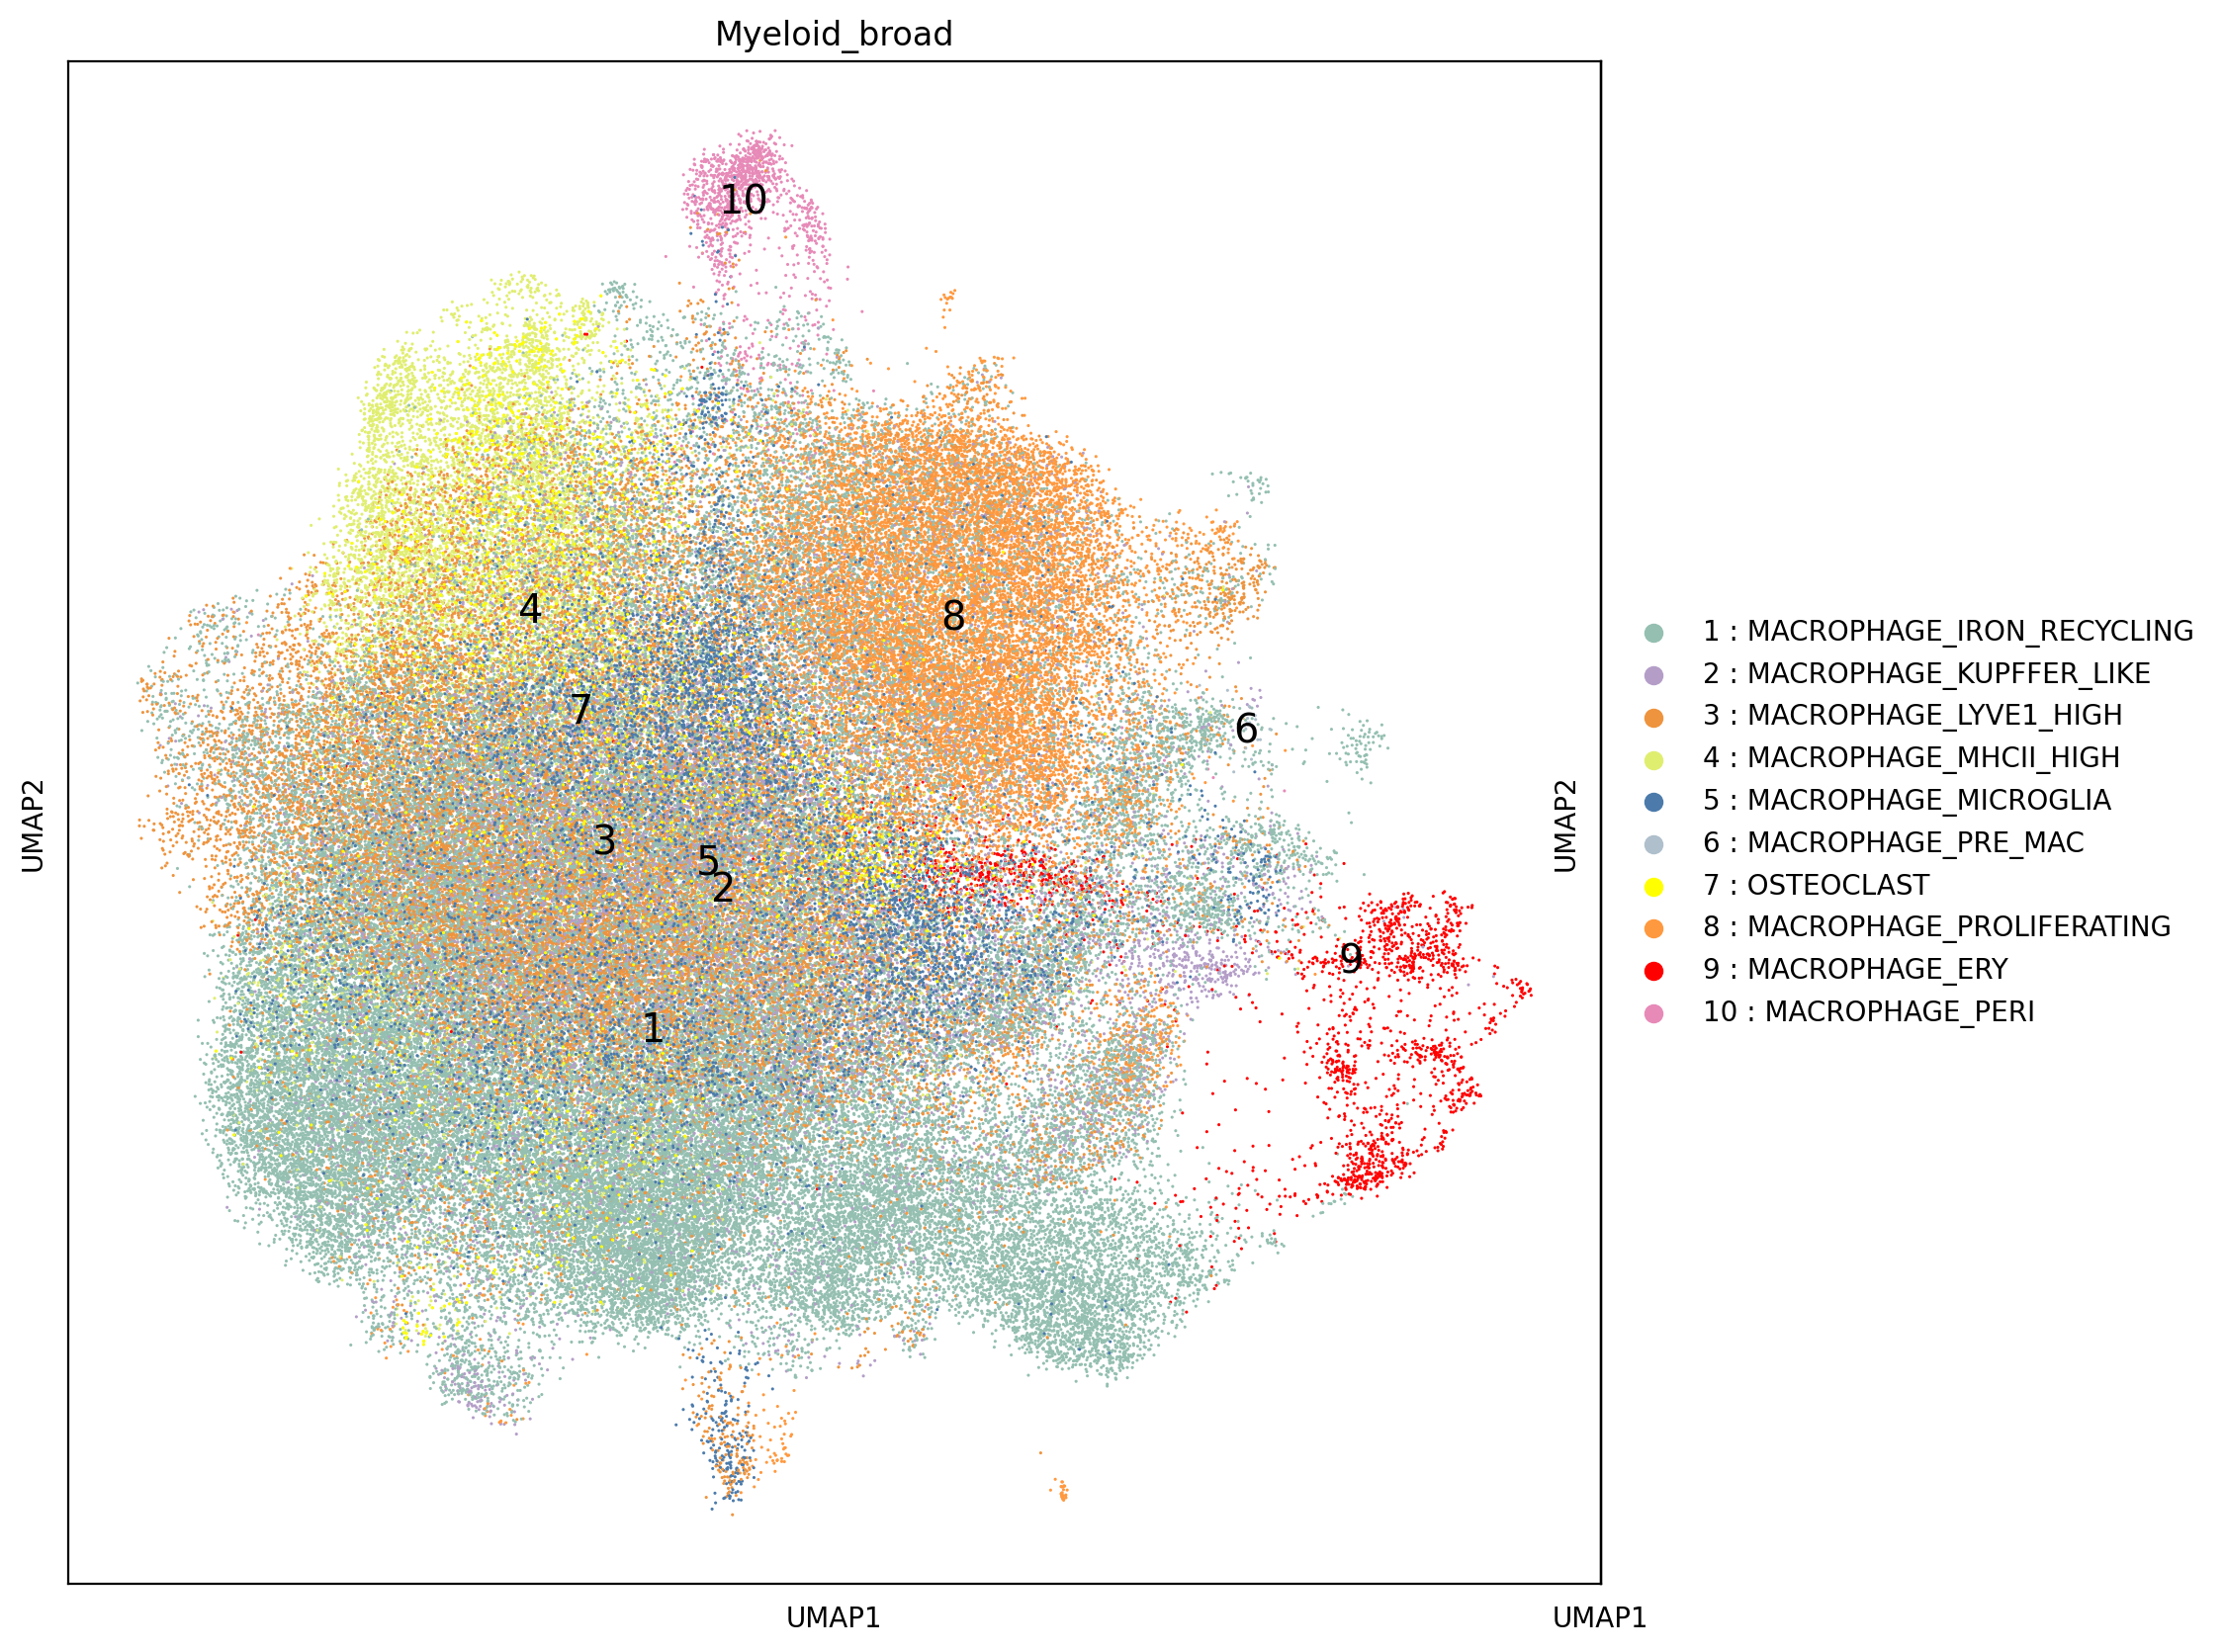

In [57]:
plt.rcdefaults()
var = "LVL3"
#Create color dictionary_cell
adata.obs[var] = adata.obs[var].astype('category')
cells = list(adata.obs[var].cat.categories)
col = list(range(1, len(adata.obs[var].cat.categories)+1))
#col = adata.uns['cell.labels_colors']
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var].astype(str)
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

col_pal = ['#94BFB1',    '#B49EC8',     '#EE943E',   '#E0EE70',  '#4C7BAB',       '#AFBFCC',    "#FFFF00", '#FF993F',    '#ff0000',  '#E78AB8', ]#"#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=5,legend_fontsize='x-large',legend_fontweight=None,ax=ax1,show=False,title="Myeloid_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"_fetal_macs_num.pdf",bbox_inches='tight')
plt.show()

In [61]:
adata_2.obs.to_csv('./integrated_metadata.csv')

In [75]:
'FCAImmP7862095'

'FCAImmP7862095'

In [98]:
adata_2.obs[adata_2.obs['Sample.lanes'].str.contains('FCAImmP7862094')].groupby(['file','Sort_id','name','donor']).apply(len)

file            Sort_id  name                          donor
FCAImmP7862094  CD45P    FCAImmP7862094_filtered.h5ad  F61      2634
dtype: int64

In [82]:
adata_2.obs[adata_2.obs['Sample.lanes'].str.contains('FCAImmP7862')].groupby(['file','Sort_id','name','donor']).apply(len)

file            Sort_id  name                          donor
FCAImmP7862094  CD45P    FCAImmP7862094_filtered.h5ad  F61      2634
FCAImmP7862096  CD45N    FCAImmP7862096_filtered.h5ad  F61      7368
dtype: int64

In [83]:
adata_2.obs[adata_2.obs['donor'].str.contains('F69')].groupby(['file','Sort_id','name','donor']).apply(len)

file            Sort_id  name                          donor
FCAImmP7964499  CD45P    FCAImmP7964499_filtered.h5ad  F69       412
FCAImmP7964500  CD45N    FCAImmP7964500_filtered.h5ad  F69       699
FCAImmP7964501  CD45N    FCAImmP7964501_filtered.h5ad  F69       894
FCAImmP7964502  CD45P    FCAImmP7964502_filtered.h5ad  F69       876
FCAImmP7964503  CD45N    FCAImmP7964503_filtered.h5ad  F69      6982
FCAImmP7964504  CD45N    FCAImmP7964504_filtered.h5ad  F69      6401
FCAImmP7964505  CD45N    FCAImmP7964505_filtered.h5ad  F69      3100
dtype: int64

In [89]:
sorted(list(adata_2.obs.loc[adata_2.obs['organ']=='LI','file'].unique()))

['FCAImmP7179363',
 'FCAImmP7179364',
 'FCAImmP7198434',
 'FCAImmP7198628',
 'FCAImmP7198629',
 'FCAImmP7198630',
 'FCAImmP7198631',
 'FCAImmP7241242',
 'FCAImmP7241243',
 'FCAImmP7277552',
 'FCAImmP7277553',
 'FCAImmP7277560',
 'FCAImmP7277561',
 'FCAImmP7292028',
 'FCAImmP7292032',
 'FCAImmP7316889',
 'FCAImmP7316890',
 'FCAImmP7316891',
 'FCAImmP7316892',
 'FCAImmP7316893',
 'FCAImmP7352192',
 'FCAImmP7352193',
 'FCAImmP7352194',
 'FCAImmP7352195',
 'FCAImmP7352196',
 'FCAImmP7528286',
 'FCAImmP7528287',
 'FCAImmP7528288',
 'FCAImmP7528289',
 'FCAImmP7528295',
 'FCAImmP7555846',
 'FCAImmP7555847',
 'FCAImmP7555856',
 'FCAImmP7555857',
 'FCAImmP7579222',
 'FCAImmP7579223',
 'FCAImmP7579226',
 'FCAImmP7579227',
 'nan']

In [66]:
list(adata_2.obs.columns)

['file',
 'name',
 'uniform_label',
 'uniform_label_expanded_merged',
 'uniform_label_lvl0',
 'organ',
 'Sample.lanes',
 'Sort_id',
 'age',
 'method',
 'donor',
 'sex',
 'Processing_method',
 'AnnatomicalPart',
 'Sample',
 'anno_lvl_2_final_clean',
 'celltype_annotation',
 'cell.labels',
 'stage',
 'lanes',
 'sort.ids',
 'fetal.ids',
 'component',
 'broad_cell.labels',
 'sequencing.type',
 'orig.dataset',
 'broad_cell_labels_organ',
 'tissue',
 'V6_old_indexes',
 'dataset_merge',
 'index_orig',
 'orig.ident',
 'nCount_RNA',
 'nFeature_RNA',
 'percent.mito',
 'new_data_handle',
 'batch',
 'HDBR_ID',
 'leiden_scvi_res15',
 'num',
 'cell.labels_num',
 'leiden_scvi_res15_num',
 'clus_prediction',
 'clus_prediction_num',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt',
 'restricted_leiden_scvi_res15',
 'umap_density_clus_prediction',
 'umap_density_clus_prediction_AEC',
 'cell.labels_v2_num',
 'scrublet_score',
 'scrublet_cluster_score',
 'scr_bh_pval',
 'scr_pva

In [ ]:
FCAImmP7862095

# Add old age groups

In [5]:
adata_2 =  sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/A1_Vx_pan_organ_integrations/A1_V10_raw_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.h5ad',backed = 'r')

In [20]:
adata_2.obs['LVL3'][adata_2.obs['LVL3'].str.contains('OSTEO')]

FCAImmP7277559-ACGCCAGAGAGTCTGG     OSTEOBLAST
FCAImmP7277559-GTCTTCGAGAGCTGGT     OSTEOBLAST
FCAImmP7277559-CAGATCATCATCATTC     OSTEOBLAST
FCAImmP7277559-CCACGGACAACTGCTA     OSTEOBLAST
FCAImmP7277559-ACTTACTTCACATGCA     OSTEOBLAST
                                       ...    
FCA_GND9332062_TGGGAAGTCTTCGGTC     OSTEOCLAST
HD_F_GON9460408_ACCCACTTCTCAAGTG    OSTEOCLAST
HD_F_GON9460408_GATTCAGAGACCACGA    OSTEOCLAST
HD_F_GON9460408_GGAACTTCACCAGGCT    OSTEOCLAST
HD_F_GON9460408_TTCTCAAGTTATTCTC    OSTEOCLAST
Name: LVL3, Length: 3252, dtype: category
Categories (181, object): ['ABT(ENTRY)', 'AS_DC', 'B1', 'B CELL', ..., 'YS_ERY', 'YS_STROMA', 'unassigned_HSPC_1', 'unassigned_HSPC_2']

In [7]:
sorted(list(adata_2.obs.loc[adata_2.obs['organ'].isin(['LI']),'LVL3'].unique()))

['ABT(ENTRY)',
 'AS_DC',
 'B1',
 'B_CYCLING',
 'CD4+T',
 'CD8+T',
 'CD8AA',
 'CHONDROCYTE',
 'CMP',
 'CYCLING_ERYTHROID',
 'CYCLING_T',
 'DC1',
 'DC2',
 'DC3',
 'DC_CYCLING',
 'DC_MIGRATORY',
 'DC_PROGENITOR',
 'DEVELOPING_NEPHRON_I',
 'DN(EARLY)_T',
 'DN(P)_T',
 'DN(Q)_T',
 'DP(P)_T',
 'DP(Q)_T',
 'EARLY_ERYTHROID',
 'EARLY_MK',
 'ELP',
 'EMBRYONIC_ERYTHROID',
 'ENDOTHELIUM',
 'ENDOTHELIUM_I',
 'ENDOTHELIUM_II',
 'ENDOTHELIUM_III',
 'ENDOTHELIUM_IV',
 'ENTEROENDOCRINE_I',
 'EOSINOPHIL_BASOPHIL',
 'EPITHELIUM_CYCLING',
 'EPITHELIUM_I',
 'EPITHELIUM_II',
 'ERYTHROID',
 'ETP',
 'FIBROBLAST',
 'FIBROBLAST_I',
 'FIBROBLAST_IX',
 'FIBROBLAST_VI',
 'FIBROBLAST_VII',
 'FIBROBLAST_X',
 'FIBROBLAST_XI',
 'FIBROBLAST_XII',
 'FIBROBLAST_XV',
 'FIBROBLAST_XVII',
 'GLIAL',
 'GMP',
 'HEPATOCYTE',
 'HSC',
 'ILC2',
 'ILC3',
 'ILC_CYCLING',
 'ILC_PRECURSOR',
 'IMMATURE_B',
 'IMMATURE_B_CELL',
 'INTERSTITIAL_CELLS_OF_CAJAL',
 'KERATINOCYTE',
 'KUPFFER_CELL_1',
 'KUPFFER_CELL_2',
 'LANGERHANS_CELLS',
 'L

In [8]:
adata.obs['age'] = adata.obs['age'].astype(str)
adata.obs.loc[adata.obs.index.isin(adata_2.obs.index),'age'] = adata_2.obs.loc[adata_2.obs.index.isin(adata.obs.index),'age'] 

<ipython-input-8-4660c081623a>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['age'] = adata.obs['age'].astype(str)


# Add latest YS_macrophage annots here:

In [9]:
# update mac_annots
# obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/A1_Vx_pan_organ_integrations/OBS_A1_V10_raw_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.csv',index_col = 0)
# obs = obs[obs.index.isin(adata.obs.index)]
# adata.obs = obs

In [10]:
adata.obs['LVL3']

FCAImmP7579224-AGATCTGGTCAGCTAT    MACROPHAGE_PROLIFERATING
FCAImmP7579224-CTTCTCTGTTCCACAA    MACROPHAGE_PROLIFERATING
FCAImmP7579224-CACAAACGTTCTGGTA       MACROPHAGE_MHCII_HIGH
FCAImmP7579224-AAACGGGCACACTGCG       MACROPHAGE_LYVE1_HIGH
FCAImmP7579224-GCAAACTAGGCTAGCA       MACROPHAGE_LYVE1_HIGH
                                             ...           
10X302_7:TTTCACACAACTTGCA              MACROPHAGE_MICROGLIA
10X302_8:CAGATACTCACACGAT              MACROPHAGE_MICROGLIA
10X302_8:GAACGTTGTACCGTCG              MACROPHAGE_MICROGLIA
10X302_8:GCCTGTTGTTCATCGA              MACROPHAGE_MICROGLIA
10X302_8:GGTAGAGCACAGTGTT              MACROPHAGE_MICROGLIA
Name: LVL3, Length: 147900, dtype: category
Categories (9, object): ['MACROPHAGE_ERY', 'MACROPHAGE_IRON_RECYCLING', 'MACROPHAGE_KUPFFER_LIKE', 'MACROPHAGE_LYVE1_HIGH', ..., 'MACROPHAGE_MICROGLIA', 'MACROPHAGE_PERI', 'MACROPHAGE_PRE_MAC', 'MACROPHAGE_PROLIFERATING']

# Add updated Brain and AGM MAC calls

In [11]:
brain_obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/add_pan_fetal_harmonised_labels_to_ys_mac/BR_MACs_new_annot_lvl4.csv',index_col =0)
agm_obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/add_pan_fetal_harmonised_labels_to_ys_mac/AGM_MACs_new_annot_lvl4.csv',index_col = 0)

In [12]:
brain_obs.loc[brain_obs['LVL3'].isin(['MACROPHAGE_MICROGLIA','MACROPHAGE_KUPFFER_LIKE']),'cell_labels_lvl4'] ='MACROPHAGE_MICROGLIA'

In [13]:
adata.obs.loc[adata.obs.index.isin(brain_obs.index),'LVL3'] = brain_obs['cell_labels_lvl4']
adata.obs.loc[adata.obs.index.isin(agm_obs.index),'LVL3'] = agm_obs['cell_labels_lvl4']

In [14]:
adata.obs.groupby(['organ','LVL3']).apply(len)

organ    LVL3                     
AGM      MACROPHAGE_IRON_RECYCLING     141
         MACROPHAGE_KUPFFER_LIKE        19
         MACROPHAGE_LYVE1_HIGH         770
         MACROPHAGE_MHCII_HIGH         102
         MACROPHAGE_MICROGLIA          179
                                      ... 
YS       MACROPHAGE_PROLIFERATING     5358
sten_BR  MACROPHAGE_IRON_RECYCLING      36
         MACROPHAGE_LYVE1_HIGH         397
         MACROPHAGE_MICROGLIA         5816
         MACROPHAGE_PROLIFERATING     1399
Length: 81, dtype: int64

# update Kupffer and Osteoclasts

In [15]:
# adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('OSTEOCLAST','MACROPHAGE_OSTEOCLAST')
# adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('KUPFFER_CELL_1','MACROPHAGE_KUPFFER_LIKE')
# adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('KUPFFER_CELL_2','MACROPHAGE_KUPFFER_LIKE')

In [16]:
sorted(list(adata.obs['LVL3'].unique()))

['MACROPHAGE_ERY',
 'MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_PERI',
 'MACROPHAGE_PRE_MAC',
 'MACROPHAGE_PROLIFERATING']

In [17]:
# adata.obs.to_csv('A2_V8_280922_Pan_organ_mac_lvl3_assignment.csv')

In [18]:
# obs = pd.read_csv('A2_V8_280922_Pan_organ_mac_lvl3_assignment.csv',index_col = 0)

In [19]:
# adata.obs = obs

# Update Gonads PCW

In [20]:
adata.obs['PCW']

FCAImmP7579224-AGATCTGGTCAGCTAT    nan
FCAImmP7579224-CTTCTCTGTTCCACAA    nan
FCAImmP7579224-CACAAACGTTCTGGTA    nan
FCAImmP7579224-AAACGGGCACACTGCG    nan
FCAImmP7579224-GCAAACTAGGCTAGCA    nan
                                  ... 
10X302_7:TTTCACACAACTTGCA          nan
10X302_8:CAGATACTCACACGAT          nan
10X302_8:GAACGTTGTACCGTCG          nan
10X302_8:GCCTGTTGTTCATCGA          nan
10X302_8:GGTAGAGCACAGTGTT          nan
Name: PCW, Length: 147900, dtype: category
Categories (18, object): ['6.0', '7.0', '7.5', '8.4', ..., '18.0', '19.0', '21.0', 'nan']

In [21]:
adata.obs['age'] = adata.obs['age'].astype(str)
adata.obs.loc[adata.obs['organ'].isin(['GO']),'age'] = (np.round(adata.obs.loc[adata.obs['organ'].isin(['GO']),'PCW'].astype(float))).astype(int).astype(str) + 'PCW'

# Let's now create pre_agm_mac assignment

In [22]:
gene_sets = {
'pre_agm_mac':['TTR',
 'CGA',
 'AGR2',
 'FCGR1A',
 'TIMD4',
 'LYVE1',
 'MRC1',
 'FOLR2',
 'NINJ1',
 'CSH1'],
'MHCII_module':["HLA-DRA",	"HLA-DPA1",	"CLEC7A","CD14","CST3","LILRA5","TREM2","STAB1",'HLA-DRB5','C5AR1','FPR3','FPR2'],
'CCR2_module':["CCR2","CD52","S100A6","BCL2A1","S100A11",],}
for i in gene_sets.keys():
#    gene_list_loc = ''.join(str(e) for e in gene_sets[i])
    gene_list_name = i
#    gene_list = list(pd.read_csv(gene_list_loc,header=None)[0])
#    gene_list = list(adata.var.index[adata.var.index.isin(gene_list)])
    gene_list = gene_sets[i]
    print(len(gene_list))
    sc.tl.score_genes(adata, gene_list, ctrl_size=200, gene_pool=None, n_bins=50, score_name=(gene_list_name + '_score'), random_state=0, copy=False, use_raw=None)

10
computing score 'pre_agm_mac_score'
    finished: added
    'pre_agm_mac_score', score of gene set (adata.obs).
    990 total control genes are used. (0:00:04)
12
computing score 'MHCII_module_score'


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


    finished: added
    'MHCII_module_score', score of gene set (adata.obs).
    989 total control genes are used. (0:00:04)
5
computing score 'CCR2_module_score'
    finished: added
    'CCR2_module_score', score of gene set (adata.obs).
    995 total control genes are used. (0:00:04)


# Consider Brain data seperately for scoring

In [23]:
adata_br = adata[adata.obs['organ'].isin(['BR'])]
for i in gene_sets.keys():
#    gene_list_loc = ''.join(str(e) for e in gene_sets[i])
    gene_list_name = i
#    gene_list = list(pd.read_csv(gene_list_loc,header=None)[0])
#    gene_list = list(adata.var.index[adata.var.index.isin(gene_list)])
    gene_list = gene_sets[i]
    print(len(gene_list))
    sc.tl.score_genes(adata_br, gene_list, ctrl_size=200, gene_pool=None, n_bins=50, score_name=(gene_list_name + '_score'), random_state=0, copy=False, use_raw=None)
pd.set_option('display.max_rows', 100)
adata_br.obs[adata_br.obs['LVL3'].str.startswith('MACROPHAGE')].groupby(['organ','LVL3']).mean()['pre_agm_mac_score']
adata.obs.loc[adata.obs.index.isin(adata_br.obs.index),[s + '_score' for s in list(gene_sets.keys())]]  = adata_br.obs[[s + '_score' for s in list(gene_sets.keys())]]

10
computing score 'pre_agm_mac_score'
    finished: added
    'pre_agm_mac_score', score of gene set (adata.obs).
    1175 total control genes are used. (0:00:00)
12
computing score 'MHCII_module_score'
    finished: added
    'MHCII_module_score', score of gene set (adata.obs).
    984 total control genes are used. (0:00:00)
5
computing score 'CCR2_module_score'


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


    finished: added
    'CCR2_module_score', score of gene set (adata.obs).
    786 total control genes are used. (0:00:00)


In [24]:
pd.set_option('display.max_rows', 100)
adata.obs[adata.obs['LVL3'].str.startswith('MACROPHAGE')].groupby(['organ','LVL3']).mean()['pre_agm_mac_score']

organ    LVL3                     
AGM      MACROPHAGE_ERY                    NaN
         MACROPHAGE_IRON_RECYCLING    0.536750
         MACROPHAGE_KUPFFER_LIKE      0.599734
         MACROPHAGE_LYVE1_HIGH        2.165655
         MACROPHAGE_MHCII_HIGH        0.030699
                                        ...   
sten_BR  MACROPHAGE_MHCII_HIGH             NaN
         MACROPHAGE_MICROGLIA        -1.012212
         MACROPHAGE_PERI                   NaN
         MACROPHAGE_PRE_MAC                NaN
         MACROPHAGE_PROLIFERATING    -1.136774
Name: pre_agm_mac_score, Length: 117, dtype: float64

# Assign TLF+ hi Macs
- rules: must be high in TLF+ siganture but cannot be high in MHCII or CCR2
- defined high by TLF+ score cannot be smaller than MHCII or CCR2

In [25]:
adata.obs['LVL4'] = adata.obs['LVL3'].astype(str)
mac_keep =  ['MACROPHAGE_PROLIFERATING',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_PERI',
 'MACROPHAGE_ERY',
 'MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_OSTEOCLAST',
 'MACROPHAGE_PRE_MAC']
tlf_macs_annot = adata.obs[adata.obs['LVL3'].isin(mac_keep)]
tlf_macs_annot['LVL_TLF_plus'] = 'MAC'

tlf_macs_annot['LVL_TLF_plus'] = tlf_macs_annot['LVL_TLF_plus'].astype(str)
tlf_macs_annot[['pre_agm_mac_score','MHCII_module_score','CCR2_module_score']] = tlf_macs_annot[['pre_agm_mac_score','MHCII_module_score','CCR2_module_score']].astype(float)
tlf_macs_annot.loc[(tlf_macs_annot['pre_agm_mac_score']>0) & (tlf_macs_annot['pre_agm_mac_score']>tlf_macs_annot['MHCII_module_score']) & (tlf_macs_annot['pre_agm_mac_score']>tlf_macs_annot['CCR2_module_score']),'LVL_TLF_plus'] = 'MACROPHAGE_TLF_hi'
tlf_macs_annot.loc[(tlf_macs_annot['pre_agm_mac_score']>0) & (tlf_macs_annot['pre_agm_mac_score']>tlf_macs_annot['MHCII_module_score']) & (tlf_macs_annot['pre_agm_mac_score']>tlf_macs_annot['CCR2_module_score']),'LVL4'] = 'MACROPHAGE_TLF_hi'

# tlf_macs_annot.loc[tlf_macs_annot['pre_agm_mac_score']>0,'LVL_TLF_plus'] = 'MACROPHAGE_PRE_AGM'
adata.obs['LVL5'] = adata.obs['LVL5'].astype(str)
adata.obs['LVL4'] = adata.obs['LVL4'].astype(str)
adata.obs.loc[adata.obs.index.isin(tlf_macs_annot.index),'LVL5'] = tlf_macs_annot['LVL_TLF_plus']
adata.obs.loc[adata.obs.index.isin(tlf_macs_annot.index),'LVL4'] = tlf_macs_annot['LVL4']

<ipython-input-25-06be391c48dc>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tlf_macs_annot['LVL_TLF_plus'] = 'MAC'


In [56]:
adata.write('./fetal_atlas_macs_pre_agm_scored.h5ad')

In [3]:
adata = sc.read('./fetal_atlas_macs_pre_agm_scored.h5ad')

In [4]:
list(sorted(adata.obs['LVL4'].unique()))

['MACROPHAGE_ERY',
 'MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_PERI',
 'MACROPHAGE_PRE_MAC',
 'MACROPHAGE_PROLIFERATING',
 'MACROPHAGE_TLF_hi']

In [5]:
# # sc.pp.neighbors(adata, n_neighbors=40,use_rep='X_scvi', n_pcs = 20)
# # sc.tl.umap(adata)
# # Clustering
# # res = 5
# sc.pl.umap(adata,color = 'LVL3',size =10)
# sc.pl.umap(adata,color = 'organ',size =10)

In [6]:
#adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/SCVi_mac_integration_degs/macs_panf_ys_brain_eliv/A1_V8_scvi_YS_macs_updated_panf_gonads_brain_build_donor_organ_corrected_120922.h5ad')

In [7]:
adata.obs["age"].unique()

['12PCW', '14PCW', '11PCW', '16PCW', '15PCW', ..., '10PCW', '4PCW', '5PCW', '6PCW', '3PCW']
Length: 14
Categories (14, object): ['3PCW', '4PCW', '5PCW', '6PCW', ..., '14PCW', '15PCW', '16PCW', '17PCW']

In [8]:
#obs  = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/meta_A2_V2_high_var_raw_YS_updated_panf_gonads_sten_brain_build.csv',index_col = 0)

In [9]:
#adata.obs.loc[adata.obs.index.isin(obs.index),'age'] = obs['age']

In [10]:
#adata.obs.loc[adata.obs.index.isin(obs.index),'age'].unique()

In [11]:
adata.obs['organ'] = adata.obs['organ'].str.replace('sten_BR','BR')

In [12]:
adata.obs['age'].unique()

['12PCW', '14PCW', '11PCW', '16PCW', '15PCW', ..., '10PCW', '4PCW', '5PCW', '6PCW', '3PCW']
Length: 14
Categories (14, object): ['3PCW', '4PCW', '5PCW', '6PCW', ..., '14PCW', '15PCW', '16PCW', '17PCW']

In [13]:
adata = adata[~adata.obs['age'].isin(['21PCW'])]
adata = adata[~adata.obs['age'].isin(['18PCW'])]
adata = adata[~adata.obs['age'].isin(['19PCW'])]
adata = adata[~adata.obs['age'].isin(['13PCW'])]

In [14]:
order = ['3PCW',
 '4PCW',
 '5PCW',
 '6PCW',
 '7PCW',
 '8PCW',
 '9PCW',
'10PCW',
 '11PCW',
 '12PCW',
'13PCW',
 '14PCW',
 '15PCW',
 '16PCW',
 '17PCW',
# '18PCW',
# '19PCW',
]
adata.obs["age"] = adata.obs["age"].astype('category').cat.reorder_categories(order)
adata.obs["stage_continuous"] = adata.obs["age"].astype('category').cat.codes
list(adata.obs["age"].astype('category').cat.codes.unique())

ValueError: items in new_categories are not the same as in old categories

In [ ]:
adata.obs.loc[adata.obs['organ'].isin(['YS']) & adata.obs['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])]

In [ ]:
organ_col = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/1_5_MAC_TLF_line_violin_plot/organ_colors.csv',index_col = 0)
col_dict = dict(zip(organ_col.index,organ_col['color']))

In [ ]:
col_dict

In [ ]:
adata_macs = adata[adata.obs['LVL3'].str.startswith('MACROPHAGE_')]

In [ ]:
adata_macs.obs['pre_agm_mac_score'] = adata_macs.obs['pre_agm_mac_score'].astype(float)

In [ ]:
import math
adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['pre_agm_mac_score']-np.mean(adata_macs.obs['pre_agm_mac_score']))/np.std(adata_macs.obs['pre_agm_mac_score'])
adata_macs.obs['transformed_pre_agm_mac_score'] = np.log(adata_macs.obs['pre_agm_mac_score'] - np.min(adata_macs.obs['pre_agm_mac_score']) + 1)
adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-np.mean(adata_macs.obs['transformed_pre_agm_mac_score']))/np.std(adata_macs.obs['transformed_pre_agm_mac_score'])
adata_macs.obs['min_max_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-np.min(adata_macs.obs['transformed_pre_agm_mac_score']))/np.max(adata_macs.obs['transformed_pre_agm_mac_score'])

In [ ]:
vmin = 0.6
vmax = 0.8
adata_plot = adata_macs[(adata_macs.obs['min_max_pre_agm_mac_score']>=vmin) & (adata_macs.obs['min_max_pre_agm_mac_score']<=vmax)]

In [ ]:
vmin = -5
vmax = 5
adata_plot = adata_macs[(adata_macs.obs['scaled_pre_agm_mac_score']>=vmin) & (adata_macs.obs['scaled_pre_agm_mac_score']<=vmax)]

In [ ]:
adata_plot.obs.loc[adata_plot.obs['organ'].isin(['BR']),'scaled_pre_agm_mac_score'] = adata_plot.obs.loc[adata_plot.obs['organ'].isin(['BR']),'scaled_pre_agm_mac_score'] + (np.std(adata_macs.obs['transformed_pre_agm_mac_score'])*2)

In [ ]:
org_order = ['YS', 'BR', 'GO','AGM', 'LI', 'SK', 'TH', 'KI', 'SP', 'GU', 'BM', 'MLN']
adata_plot.obs['organ'] = adata_plot.obs['organ'].astype('category').cat.reorder_categories(org_order)

In [ ]:
adata_plot.obs['LVL5']
adata_plot.obs['LVL6'] = adata_plot.obs['organ'].astype(str)
adata_plot.obs.loc[adata.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL6'] = adata_plot.obs.loc[adata.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL5']

In [ ]:
data = adata_plot.obs[['organ','scaled_pre_agm_mac_score','LVL5']]
data['col'] = data['organ'].map(col_dict)
col_dict =[(key, col_dict[key]) for key in list(adata_plot.obs['organ'].cat.categories) if key in col_dict]
col_dict = dict(col_dict)

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(10,6))
sns.set_palette("RdBu")
# sns.set_style("darkgrid")
sns.violinplot(x='organ', y='scaled_pre_agm_mac_score',hue = 'LVL5', data=data,split= True,size=5,width = 1, cut=0)#palette = []
sns.stripplot(x='organ', y='scaled_pre_agm_mac_score', data=data,  palette =col_dict ,jitter=True, zorder=1,alpha=.8,size=1)

# sns.swarmplot(x='organ', y='min_max_pre_agm_mac_score', data=data, color="k", alpha=0.8)

plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
plt.title("Organ-wise TLF+ Macrophage distribution")
plt.ylabel("variance-scaled TLF+ module score")
plt.xlabel("Organs")
plt.savefig(('./v5_Violin_organ_wise_tlf_distribution.pdf'),dpi=300,bbox_inches='tight')
plt.show()

# Order by magnitude

In [ ]:
adata_macs = adata[adata.obs['LVL3'].str.startswith('MACROPHAGE_')]

In [ ]:
adata_plot = adata_macs
adata_plot.obs['LVL5']
adata_plot.obs['LVL6'] = adata_plot.obs['organ'].astype(str)
adata_plot.obs.loc[adata.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL6'] = adata_plot.obs.loc[adata.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL5']

In [ ]:
data = adata_plot.obs[['organ','scaled_pre_agm_mac_score','LVL5']]
data['col'] = data['organ'].map(col_dict)
col_dict =[(key, col_dict[key]) for key in list(adata_plot.obs['organ'].cat.categories) if key in col_dict]
col_dict = dict(col_dict)

In [ ]:
organ_col = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/1_5_MAC_TLF_line_violin_plot/organ_colors.csv',index_col = 0)
col_dict = dict(zip(organ_col.index,organ_col['color']))

In [ ]:
ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
for organ in ranker['organ'].unique():
    rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
rank_prop = rank_prop.sort_values('prop',ascending = False)
data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

In [ ]:
rank_prop

# plotter module

In [ ]:
##Subsample by frac
data2= data[:]
grouped = data2.groupby('organ')
df = grouped.apply(lambda x: x.sample(frac=0.1))
df = df.droplevel('organ')
keep = df.index
data_striplot = data[data.index.isin(keep)]

In [ ]:
adata_plotter = adata_plot[:]

In [ ]:
plt.rcdefaults()
cell_state = 'MACROPHAGE_TLF_hi'

color_key = col_dict

plt.rcParams.update({'font.size': 15})
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(5, 2), dpi=200)
ax1 = fig.add_subplot()

cell_state = 'MACROPHAGE_TLF_hi'
x = list(adata_plotter.obs['age'].cat.categories)
for organ in adata_plotter.obs['organ'].unique():
    print(organ)
    obs = adata_plotter.obs[adata_plotter.obs['organ'].isin([organ])]
    # grab proportion per organ
    tbl = pd.crosstab(obs['LVL4'],adata_plotter.obs['age'])
    tbl_count = tbl.copy()
    tbl = (tbl/tbl.sum())*100
    tbl = pd.DataFrame(tbl.loc[cell_state])
    tbl_count = pd.DataFrame(tbl_count.loc[cell_state])
    empty = pd.DataFrame(np.nan,index = list(set(tbl.index) ^ set(x)),columns = tbl.columns)
    tbl = tbl.append(empty).loc[x]
    if organ == 'YS':
        tbl.loc['4PCW'] = 71.7
        tbl.loc['7PCW'] = 55.7
    if organ == 'BR':
        tbl.loc['3PCW'] = 60.7
        tbl.loc['4PCW'] = 80.7
        tbl.loc['5PCW'] = 85
    if organ == 'LI':
        tbl = tbl*5
    tbl_count = tbl_count.append(empty).loc[x]
    y1 = tbl.iloc[:,0]
    
    size_counts = np.log10(tbl_count)
    y1_size = list(size_counts[cell_state]*50)

    #figure(figsize=(5, 10), dpi=80)
    
    if organ == 'KI':
        s2mask = np.isfinite(y1)
        ax1.plot(pd.DataFrame(x,index=x)[s2mask].iloc[:,0],y1[s2mask],c=color_key[organ],linestyle='-',zorder=3)
    if organ == 'LI':
        s2mask = np.isfinite(y1)
        ax1.plot(pd.DataFrame(x,index=x)[s2mask].iloc[:,0],y1[s2mask],c=color_key[organ],linestyle='-',zorder=3)
    
    ax1.plot(x,y1,c=color_key[organ],linestyle = None,zorder=3)
    ax1.scatter(x,y1,c=color_key[organ],s = y1_size ,marker='o', cmap='turbo',zorder=10  ) #y1*10

#     ymin = np.nanmin((list(y1) ))- (np.nanmin((list(y1)))*0.1)
#     ymax = np.nanmax((list(y1) )) + (np.nanmax((list(y1) ))*0.1)
    ymin = 0
    ymax = 100

    plt.grid(False)
    plt.xticks(rotation=90)
    positions = (ymin, ((ymax - ymin)/2)+ymin, ymax)

    labels = (str(round(np.nanmin(y1),2)),str(round(((np.nanmax(y1) - np.nanmin(y1))/2 ) + np.nanmin(y1),2)),  str(round(np.nanmax(y1),2)))
    plt.yticks(positions, labels)
    
    plt.xlabel("Gestational time")
    plt.ylabel("Proportion TLF+ enriched Macrophages")
    plt.ylim(ymin, ymax)
    #plt.title("Proportion " + cell_state + " enriched cells")
    
    # offset legend
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_key.values()]
plt.ylim(ymin, ymax)
ax1.set_yticklabels([0,50,100])

msizes = np.array([1, 2, 3, 4, 5, 6])

l1, = plt.plot([],[], 'or', markersize=msizes[2])
l2, = plt.plot([],[], 'or', markersize=msizes[3])
l3, = plt.plot([],[], 'or', markersize=msizes[4])
l4, = plt.plot([],[], 'or', markersize=msizes[5])
labels = ['2', '3', '4', '5']
legend2 = plt.legend([l1, l2, l3, l4], labels, ncol=1, fontsize=5, handlelength=2, title='log10 cell counts', scatterpoints = 1,bbox_to_anchor=(1.3, 0.5))
plt.setp(legend2.get_title(),fontsize='xx-small')
ax1.add_artist(legend2)
plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.3, 0.5))

plt.savefig(('./'+cell_state+'_plot.pdf'),dpi=300,bbox_inches='tight')

In [ ]:
adata.write('./integrated_macs_fetal_pan_organ_scored.h5ad')

In [368]:
adata = sc.read('./integrated_macs_fetal_pan_organ_scored.h5ad')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'integrated_macs_fetal_pan_organ_scored.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [369]:
obs = adata_plotter.obs[adata_plotter.obs['organ'].isin(['TH'])]
# grab proportion per organ
tbl = pd.crosstab(obs['LVL4'],adata_plotter.obs['age'])
tbl_count = tbl.copy()
tbl = (tbl/tbl.sum())*100
tbl = pd.DataFrame(tbl.loc[cell_state])
tbl_count = pd.DataFrame(tbl_count.loc[cell_state])
empty = pd.DataFrame(np.nan,index = list(set(tbl.index) ^ set(x)),columns = tbl.columns)
tbl = tbl.append(empty).loc[x]
tbl

NameError: name 'adata_plotter' is not defined

In [ ]:
adata.obs[adata.obs['organ'].isin(['BR'])].groupby(['age']).apply(len)
tbl

In [ ]:
adata_plotter = adata_plotter[~adata_plotter.obs['age'].isin(['13PCW'])]

In [ ]:
plt.rcdefaults()
cell_state = 'MACROPHAGE_TLF_hi'

color_key = col_dict

plt.rcParams.update({'font.size': 15})
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(5, 2), dpi=200)
ax1 = fig.add_subplot()

cell_state = 'MACROPHAGE_TLF_hi'
x = list(adata_plotter.obs['age'].cat.categories)
for organ in adata_plotter.obs['organ'].unique():
    print(organ)
    obs = adata_plotter.obs[adata_plotter.obs['organ'].isin([organ])]
    # grab proportion per organ
    tbl = pd.crosstab(obs['LVL4'],adata_plotter.obs['age'])
    tbl_count = tbl.copy()
    tbl = (tbl/tbl.sum())*100
    tbl = pd.DataFrame(tbl.loc[cell_state])
    tbl_count = pd.DataFrame(tbl_count.loc[cell_state])
    empty = pd.DataFrame(np.nan,index = list(set(tbl.index) ^ set(x)),columns = tbl.columns)
    tbl = tbl.append(empty).loc[x]
    if organ == 'YS':
        tbl.loc['4PCW'] = 71.7
        tbl.loc['7PCW'] = 55.7
    if organ == 'BR':
        tbl.loc['3PCW'] = 60.7
        tbl.loc['4PCW'] = 80.7
        tbl.loc['5PCW'] = 80.7
        tbl.loc['6PCW'] = 50
        tbl.loc['7PCW'] = 40
        tbl.loc['8PCW'] = 25
    if organ == 'LI':
        tbl = tbl*5
        tbl.loc['9PCW'] = 15
    if organ == 'GO':
#         tbl = tbl*5
        tbl.loc['10PCW'] = 25
    tbl_count = tbl_count.append(empty).loc[x]
    y1 = tbl.iloc[:,0]
    
    size_counts = np.log10(tbl_count)
    y1_size = list(size_counts[cell_state]*50)

    #figure(figsize=(5, 10), dpi=80)
    
    if organ == 'KI':
        s2mask = np.isfinite(y1)
        ax1.plot(pd.DataFrame(x,index=x)[s2mask].iloc[:,0],y1[s2mask],c=color_key[organ],linestyle='-',zorder=3)
    if organ == 'LI':
        s2mask = np.isfinite(y1)
        ax1.plot(pd.DataFrame(x,index=x)[s2mask].iloc[:,0],y1[s2mask],c=color_key[organ],linestyle='-',zorder=3)
#    if organ == 'SK':
#        s2mask = np.isfinite(y1)
#        ax1.plot(pd.DataFrame(x,index=x)[s2mask].iloc[:,0],y1[s2mask],c=color_key[organ],linestyle='-',zorder=1)
    
    ax1.plot(x,y1,c=color_key[organ],linestyle = None,zorder=3)
    ax1.scatter(x,y1,c=color_key[organ],s = y1_size ,marker='o', cmap='turbo',zorder=10  ) #y1*10

#     ymin = np.nanmin((list(y1) ))- (np.nanmin((list(y1)))*0.1)
#     ymax = np.nanmax((list(y1) )) + (np.nanmax((list(y1) ))*0.1)
    ymin = 0
    ymax = 100

    plt.grid(False)
    plt.xticks(rotation=90)
    positions = (ymin, ((ymax - ymin)/2)+ymin, ymax)

    labels = (str(round(np.nanmin(y1),2)),str(round(((np.nanmax(y1) - np.nanmin(y1))/2 ) + np.nanmin(y1),2)),  str(round(np.nanmax(y1),2)))
    plt.yticks(positions, labels)
    
    plt.xlabel("Gestational time (PCW)",fontsize = 10)
    plt.ylabel("% TLF+ enrichment",fontsize = 10)
    plt.ylim(ymin, ymax)
    #plt.title("Proportion " + cell_state + " enriched cells")
    
    # offset legend
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_key.values()]
plt.ylim(ymin, ymax)
ax1.set_yticklabels([0,50,100])
ax1.set_xticklabels(['3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
'13',
 '14',
 '15',
 '16',
 '17'])

msizes = np.array([2, 3, 4, 5, 6, 7])

l1, = plt.plot([],[], 'or', markersize=msizes[2])
l2, = plt.plot([],[], 'or', markersize=msizes[3])
l3, = plt.plot([],[], 'or', markersize=msizes[4])
l4, = plt.plot([],[], 'or', markersize=msizes[5])
labels = ['2', '3', '4', '5']
legend2 = plt.legend([l1, l2, l3, l4], labels, ncol=1, fontsize=5, handlelength=2, title='log10 cell counts', scatterpoints = 1,bbox_to_anchor=(1.3, 0.5))
plt.setp(legend2.get_title(),fontsize='xx-small')
ax1.add_artist(legend2)
plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.3, 0.5))
plt.title("Proportion of pre-AGM mac module enrichment",fontsize = 10, y =1.1)

plt.savefig(('./'+cell_state+'_v4_plot.pdf'),dpi=300,bbox_inches='tight')

# Plot violin plots

In [2]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/1_5_MAC_TLF_line_violin_plot/V3_plots/fetal_atlas_macs_pre_agm_scored.h5ad')

In [3]:
organ_col = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/1_5_MAC_TLF_line_violin_plot/organ_colors.csv',index_col = 0)
col_dict = dict(zip(organ_col.index,organ_col['color']))

# Order by magnitude

In [4]:
adata_macs = adata[adata.obs['LVL3'].str.startswith('MACROPHAGE_')]

In [46]:
adata_plot = adata_macs
adata_plot.obs['LVL5']
adata_plot.obs['LVL6'] = adata_plot.obs['organ'].astype(str)
adata_plot.obs.loc[adata.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL6'] = adata_plot.obs.loc[adata.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL5']

In [47]:
import math
adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['pre_agm_mac_score']-np.mean(adata_macs.obs['pre_agm_mac_score']))/np.std(adata_macs.obs['pre_agm_mac_score'])
adata_macs.obs['transformed_pre_agm_mac_score'] = np.log(adata_macs.obs['pre_agm_mac_score'] - np.min(adata_macs.obs['pre_agm_mac_score']) + 1)
adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-np.mean(adata_macs.obs['transformed_pre_agm_mac_score']))/np.std(adata_macs.obs['transformed_pre_agm_mac_score'])
adata_macs.obs['min_max_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-np.min(adata_macs.obs['transformed_pre_agm_mac_score']))/np.max(adata_macs.obs['transformed_pre_agm_mac_score'])
data = adata_plot.obs[['organ','scaled_pre_agm_mac_score','LVL5']]
data['col'] = data['organ'].map(col_dict)
col_dict =[(key, col_dict[key]) for key in list(adata_plot.obs['organ'].cat.categories) if key in col_dict]
col_dict = dict(col_dict)

<ipython-input-47-45dd4fa11bea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['col'] = data['organ'].map(col_dict)


# Try scaling by organ

In [48]:
# # V3 let's use modified Z score instead
# from scipy.stats import median_abs_deviation as MAD
# score_style = 'min_tresh'#,'Mean' #'Mean', 'MAD','min_tresh'
# for organ in adata_macs.obs['organ'].unique():
#     organ_temp = adata_macs.obs[adata_macs.obs['organ'].isin([organ])]
#     organ_temp['transformed_pre_agm_mac_score'] =  np.log(organ_temp['pre_agm_mac_score'] - np.min(organ_temp['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score'] #
#     # Scale around the mean for TLF socre per organ
#     if score_style == 'MAD':
#         print('MAD')
#         organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['transformed_pre_agm_mac_score']-np.median(organ_temp['transformed_pre_agm_mac_score'])))/MAD(organ_temp['transformed_pre_agm_mac_score'])
#     elif score_style == 'min_tresh':
#         print('min_tresh')
#         organ_temp['scaled_pre_agm_mac_score'] = (organ_temp['transformed_pre_agm_mac_score']-min(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score']))/np.std(organ_temp['transformed_pre_agm_mac_score'])
#     else:
#         print('mean')
#         organ_temp['scaled_pre_agm_mac_score'] = (organ_temp['transformed_pre_agm_mac_score']-np.mean(organ_temp['transformed_pre_agm_mac_score']))/np.std(organ_temp['transformed_pre_agm_mac_score'])
#     adata_macs.obs.loc[adata_macs.obs['organ'].isin([organ]),['transformed_pre_agm_mac_score','scaled_pre_agm_mac_score','min_max_pre_agm_mac_score']] = organ_temp[['transformed_pre_agm_mac_score','scaled_pre_agm_mac_score','min_max_pre_agm_mac_score']] 

In [49]:
adata_macs.obs['pre_agm_mac_score']

FCAImmP7579224-AGATCTGGTCAGCTAT   -4.164646
FCAImmP7579224-CTTCTCTGTTCCACAA    0.817172
FCAImmP7579224-CACAAACGTTCTGGTA   -6.895960
FCAImmP7579224-AAACGGGCACACTGCG    0.002020
FCAImmP7579224-GCAAACTAGGCTAGCA    0.002020
                                     ...   
10X302_7:TTTCACACAACTTGCA         -3.407071
10X302_8:CAGATACTCACACGAT         -3.152525
10X302_8:GAACGTTGTACCGTCG         -2.710101
10X302_8:GCCTGTTGTTCATCGA         -2.878788
10X302_8:GGTAGAGCACAGTGTT         -1.954545
Name: pre_agm_mac_score, Length: 147858, dtype: float64

In [50]:
# penalise any cells with >ccr2 or > MHII scores
for organ in adata_macs.obs['organ'].unique():
    organ
    organ_temp = adata_macs.obs[adata_macs.obs['organ'].isin([organ])]
    organ_temp.loc[(~organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi'])) & (organ_temp['pre_agm_mac_score']>np.min(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'pre_agm_mac_score'])),'pre_agm_mac_score'] = np.max(organ_temp.loc[(~organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi'])) & (organ_temp['pre_agm_mac_score']<np.min(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'pre_agm_mac_score'])),'pre_agm_mac_score'])#organ_temp.loc[(~organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi'])) & (organ_temp['pre_agm_mac_score']>np.min(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'pre_agm_mac_score'])),'pre_agm_mac_score'] - np.max(organ_temp.loc[(organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi'])),'pre_agm_mac_score']) 
    adata_macs.obs.loc[adata_macs.obs['organ'].isin([organ]),['pre_agm_mac_score']] = organ_temp[['pre_agm_mac_score']] 

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [51]:
# V3 let's use modified Z score instead
from scipy.stats import median_abs_deviation as MAD
adata_macs.obs['scaled_pre_agm_mac_score'] = 0
score_style = 'min_tresh'#,'Mean' #'Mean', 'MAD','min_tresh' #enrich_mean
scale = 'organ'
if scale == 'all':
    adata_macs.obs['transformed_pre_agm_mac_score'] =  np.log(adata_macs.obs['pre_agm_mac_score'] - np.min(adata_macs.obs['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score'] #
    # Scale around the mean for TLF socre per organ
    if score_style == 'MAD':
        print('MAD')
        adata_macs.obs['scaled_pre_agm_mac_score'] = ((adata_macs.obs['transformed_pre_agm_mac_score']-np.median(adata_macs.obs['transformed_pre_agm_mac_score'])))/MAD(adata_macs.obs['transformed_pre_agm_mac_score'])
    elif score_style == 'min_tresh':
        print('min_tresh')
        adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-min(adata_macs.obs.loc[adata_macs.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score']))/np.std(adata_macs.obs['transformed_pre_agm_mac_score'])
    else:
        print('mean')
        adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-np.mean(adata_macs.obs['transformed_pre_agm_mac_score']))/np.std(adata_macs.obs['transformed_pre_agm_mac_score'])
 #    adata_macs.obs.loc[adata_macs.obs['organ'].isin([organ]),['transformed_pre_agm_mac_score','scaled_pre_agm_mac_score','min_max_pre_agm_mac_score']] = organ_temp[['transformed_pre_agm_mac_score','scaled_pre_agm_mac_score','min_max_pre_agm_mac_score']] 

if scale == 'organ': 
    concat = pd.DataFrame(columns = adata_macs.obs.columns)
    for organ in adata_macs.obs['organ'].unique():
        print(organ)
        organ_temp = adata_macs.obs[adata_macs.obs['organ'].isin([organ])]
        organ_temp['transformed_pre_agm_mac_score'] =  np.log(adata_macs.obs['pre_agm_mac_score'] - np.min(adata_macs.obs['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score']#np.log(organ_temp['pre_agm_mac_score'] - np.min(organ_temp['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score'] #
        # Scale around the mean for TLF socre per organ
        if score_style == 'MAD':
            print('MAD')
            organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['transformed_pre_agm_mac_score']-np.median(organ_temp['transformed_pre_agm_mac_score'])))/MAD(organ_temp['transformed_pre_agm_mac_score'])
        elif score_style == 'min_tresh':
            print('min_tresh')
            organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['transformed_pre_agm_mac_score']-np.min(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score']))/np.std(organ_temp['transformed_pre_agm_mac_score'])) #min(adata_macs.obs.loc[adata_macs.obs['LVL5'].isin(['MACROPHAGE_pre_agm_hi']),'transformed_pre_agm_mac_score']))                                            
        elif score_style == 'enrich_mean':
            print('enrich_mean')
            # new module scale by mean of just the enriched population
            organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['transformed_pre_agm_mac_score']-np.mean(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score']))/np.std(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score'])) #min(adata_macs.obs.loc[adata_macs.obs['LVL5'].isin(['MACROPHAGE_pre_agm_hi']),'transformed_pre_agm_mac_score']))
        else:
            print('mean')
            organ_temp['scaled_pre_agm_mac_score'] = (organ_temp['transformed_pre_agm_mac_score']-np.mean(organ_temp['transformed_pre_agm_mac_score']))/np.std(organ_temp['transformed_pre_agm_mac_score'])
        adata_macs.obs.loc[adata_macs.obs.index.isin(organ_temp.index),'scaled_pre_agm_mac_score'] = organ_temp['scaled_pre_agm_mac_score']
        concat = pd.concat([organ_temp,concat])

SK
min_tresh
SP


<ipython-input-51-49d53feed14b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organ_temp['transformed_pre_agm_mac_score'] =  np.log(adata_macs.obs['pre_agm_mac_score'] - np.min(adata_macs.obs['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score']#np.log(organ_temp['pre_agm_mac_score'] - np.min(organ_temp['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score'] #
<ipython-input-51-49d53feed14b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['

min_tresh
LI
min_tresh
TH
min_tresh
GU
min_tresh
BM
min_tresh
KI
min_tresh
MLN
min_tresh
YS
min_tresh
BR
min_tresh
GO
min_tresh
AGM
min_tresh


In [52]:
organ_temp['pre_agm_mac_score']

AAATGCCTCAGGCGAA-0     0.169697
AACCATGAGCCACTAT-0     0.169697
AACGTTGAGTCCCACG-0     0.169697
AACTCCCGTAATTGGA-0     0.952525
AACTCCCTCAAGATCC-0     1.935354
                        ...    
TTCGAAGCAACGATCT-3     6.473737
TTGGAACAGCGATCCC-3     0.169697
TTTATGCCACTAGTAC-3    11.225253
TTTCCTCTCGGCGCTA-3     5.088889
TTTGTCAAGAGCTGCA-3     4.077778
Name: pre_agm_mac_score, Length: 1211, dtype: float64

In [53]:
organ_temp['transformed_pre_agm_mac_score'] 

AAATGCCTCAGGCGAA-0    3.419315
AACCATGAGCCACTAT-0    3.419315
AACGTTGAGTCCCACG-0    3.419315
AACTCCCGTAATTGGA-0    3.444618
AACTCCCTCAAGATCC-0    3.475505
                        ...   
TTCGAAGCAACGATCT-3    3.606924
TTGGAACAGCGATCCC-3    3.419315
TTTATGCCACTAGTAC-3    3.728197
TTTCCTCTCGGCGCTA-3    3.568622
TTTGTCAAGAGCTGCA-3    3.539700
Name: transformed_pre_agm_mac_score, Length: 1211, dtype: float64

In [54]:
concat

file                          name  \
AAATGCCTCAGGCGAA-0                          nan                           nan   
AACCATGAGCCACTAT-0                          nan                           nan   
AACGTTGAGTCCCACG-0                          nan                           nan   
AACTCCCGTAATTGGA-0                          nan                           nan   
AACTCCCTCAAGATCC-0                          nan                           nan   
...                                         ...                           ...   
FCAImmP7862096-CCATGTCAGGCGCTCT  FCAImmP7862096  FCAImmP7862096_filtered.h5ad   
FCAImmP7862096-CTGCTGTCAATCCAAC  FCAImmP7862096  FCAImmP7862096_filtered.h5ad   
FCAImmP7862096-CACATAGAGAACAATC  FCAImmP7862096  FCAImmP7862096_filtered.h5ad   
FCAImmP7862096-GTCTTCGTCATCGATG  FCAImmP7862096  FCAImmP7862096_filtered.h5ad   
FCAImmP7803042-TCTCATATCCTATGTT  FCAImmP7803042  FCAImmP7803042_filtered.h5ad   

                                uniform_label uniform_label_expanded_merged  \
AAATGCCTCAGGCGAA-0                        nan                           nan   
AACCATGAGCCACTAT-0                        nan                           nan   
AACGTTGAGTCCCACG-0                        nan                           nan   
AACTCCCGTAATTGGA-0                        nan                           nan   
AACTCCCTCAAGATCC-0                        nan                           nan   
...                                       ...                           ...   
FCAImmP7862096-CCATGTCAGGCGCTCT     ERYTHROID                     ERYTHROID   
FCAImmP7862096-CTGCTGTCAATCCAAC     ERYTHROID                     ERYTHROID   
FCAImmP7862096-CACATAGAGAACAATC    MACROPHAGE                    MACROPHAGE   
FCAImmP7862096-GTCTTCGTCATCGATG    MACROPHAGE                    MACROPHAGE   
FCAImmP7803042-TCTCATATCCTATGTT           nan                           nan   

                                uniform_label_lvl0 organ    Sample.lanes  \
AAATGCCTCAGGCGAA-0                             nan   AGM             nan   
AACCATGAGCCACTAT-0                             nan   AGM             nan   
AACGTTGAGTCCCACG-0                             nan   AGM             nan   
AACTCCCGTAATTGGA-0                             nan   AGM             nan   
AACTCCCTCAAGATCC-0                             nan   AGM             nan   
...                                            ...   ...             ...   
FCAImmP7862096-CCATGTCAGGCGCTCT          ERYTHROID    SK  FCAImmP7862096   
FCAImmP7862096-CTGCTGTCAATCCAAC          ERYTHROID    SK  FCAImmP7862096   
FCAImmP7862096-CACATAGAGAACAATC            MYELOID    SK  FCAImmP7862096   
FCAImmP7862096-GTCTTCGTCATCGATG            MYELOID    SK  FCAImmP7862096   
FCAImmP7803042-TCTCATATCCTATGTT                nan    SK  FCAImmP7803042   

                                Sort_id    age method  ...  \
AAATGCCTCAGGCGAA-0                  nan   6PCW    nan  ...   
AACCATGAGCCACTAT-0                  nan   6PCW    nan  ...   
AACGTTGAGTCCCACG-0                  nan   6PCW    nan  ...   
AACTCCCGTAATTGGA-0                  nan   6PCW    nan  ...   
AACTCCCTCAAGATCC-0                  nan   6PCW    nan  ...   
...                                 ...    ...    ...  ...   
FCAImmP7862096-CCATGTCAGGCGCTCT   CD45N   7PCW   5GEX  ...   
FCAImmP7862096-CTGCTGTCAATCCAAC   CD45N   7PCW   5GEX  ...   
FCAImmP7862096-CACATAGAGAACAATC   CD45N   7PCW   5GEX  ...   
FCAImmP7862096-GTCTTCGTCATCGATG   CD45N   7PCW   5GEX  ...   
FCAImmP7803042-TCTCATATCCTATGTT   CD45N  14PCW   5GEX  ...   

                                pf_consensus_clus_prediction IG_annot  \
AAATGCCTCAGGCGAA-0                                       nan      nan   
AACCATGAGCCACTAT-0                                       nan      nan   
AACGTTGAGTCCCACG-0                                       nan      nan   
AACTCCCGTAATTGGA-0                                       nan      nan   
AACTCCCTCAAGATCC-0                                       nan      nan   
...                      

In [55]:
max(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score'])

3.9666259683307064

In [56]:
max(organ_temp.loc[organ_temp['LVL5'].isin(['MAC']),'transformed_pre_agm_mac_score'])

3.4193150885934154

In [57]:
np.std(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score'])
np.std(organ_temp['transformed_pre_agm_mac_score'])

0.08123279259142255

In [58]:
adata_plot = adata_macs[:]

In [59]:
# vmin = 0.6
# vmax = 0.8
# adata_plot = adata_macs[(adata_macs.obs['min_max_pre_agm_mac_score']>=vmin) & (adata_macs.obs['min_max_pre_agm_mac_score']<=vmax)]

In [60]:
# vmin = -5
# vmax = 5
# adata_plot = adata_macs[(adata_macs.obs['scaled_pre_agm_mac_score']>=vmin) & (adata_macs.obs['scaled_pre_agm_mac_score']<=vmax)]

In [61]:
 #adata_plot.obs.loc[adata_plot.obs['organ'].isin(['BR']),'scaled_pre_agm_mac_score'] = adata_plot.obs.loc[adata_plot.obs['organ'].isin(['BR']),'scaled_pre_agm_mac_score'] + (np.std(adata_macs.obs['transformed_pre_agm_mac_score'])*2)

In [62]:
org_order = ['YS', 'BR', 'GO','AGM', 'LI', 'SK', 'TH', 'KI', 'SP', 'GU', 'BM', 'MLN']
adata_plot.obs['organ'] = adata_plot.obs['organ'].astype('category').cat.reorder_categories(org_order)

<ipython-input-62-e4a10860aeae>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_plot.obs['organ'] = adata_plot.obs['organ'].astype('category').cat.reorder_categories(org_order)


In [63]:
adata.obs['LVL5']

FCAImmP7579224-AGATCTGGTCAGCTAT                  MAC
FCAImmP7579224-CTTCTCTGTTCCACAA    MACROPHAGE_TLF_hi
FCAImmP7579224-CACAAACGTTCTGGTA                  MAC
FCAImmP7579224-AAACGGGCACACTGCG                  MAC
FCAImmP7579224-GCAAACTAGGCTAGCA                  MAC
                                         ...        
10X302_7:TTTCACACAACTTGCA                        MAC
10X302_8:CAGATACTCACACGAT                        MAC
10X302_8:GAACGTTGTACCGTCG                        MAC
10X302_8:GCCTGTTGTTCATCGA                        MAC
10X302_8:GGTAGAGCACAGTGTT                        MAC
Name: LVL5, Length: 147858, dtype: category
Categories (2, object): ['MAC', 'MACROPHAGE_TLF_hi']

In [64]:
adata_plot.obs['LVL5']
adata_plot.obs['LVL6'] = adata_plot.obs['organ'].astype(str)
adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL6'] = adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL5']

In [65]:
data = concat[['organ','scaled_pre_agm_mac_score','LVL5']]
data['col'] = data['organ'].map(col_dict)
col_dict =[(key, col_dict[key]) for key in list(adata_plot.obs['organ'].cat.categories) if key in col_dict]
col_dict = dict(col_dict)

<ipython-input-65-247f53bc16ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['col'] = data['organ'].map(col_dict)


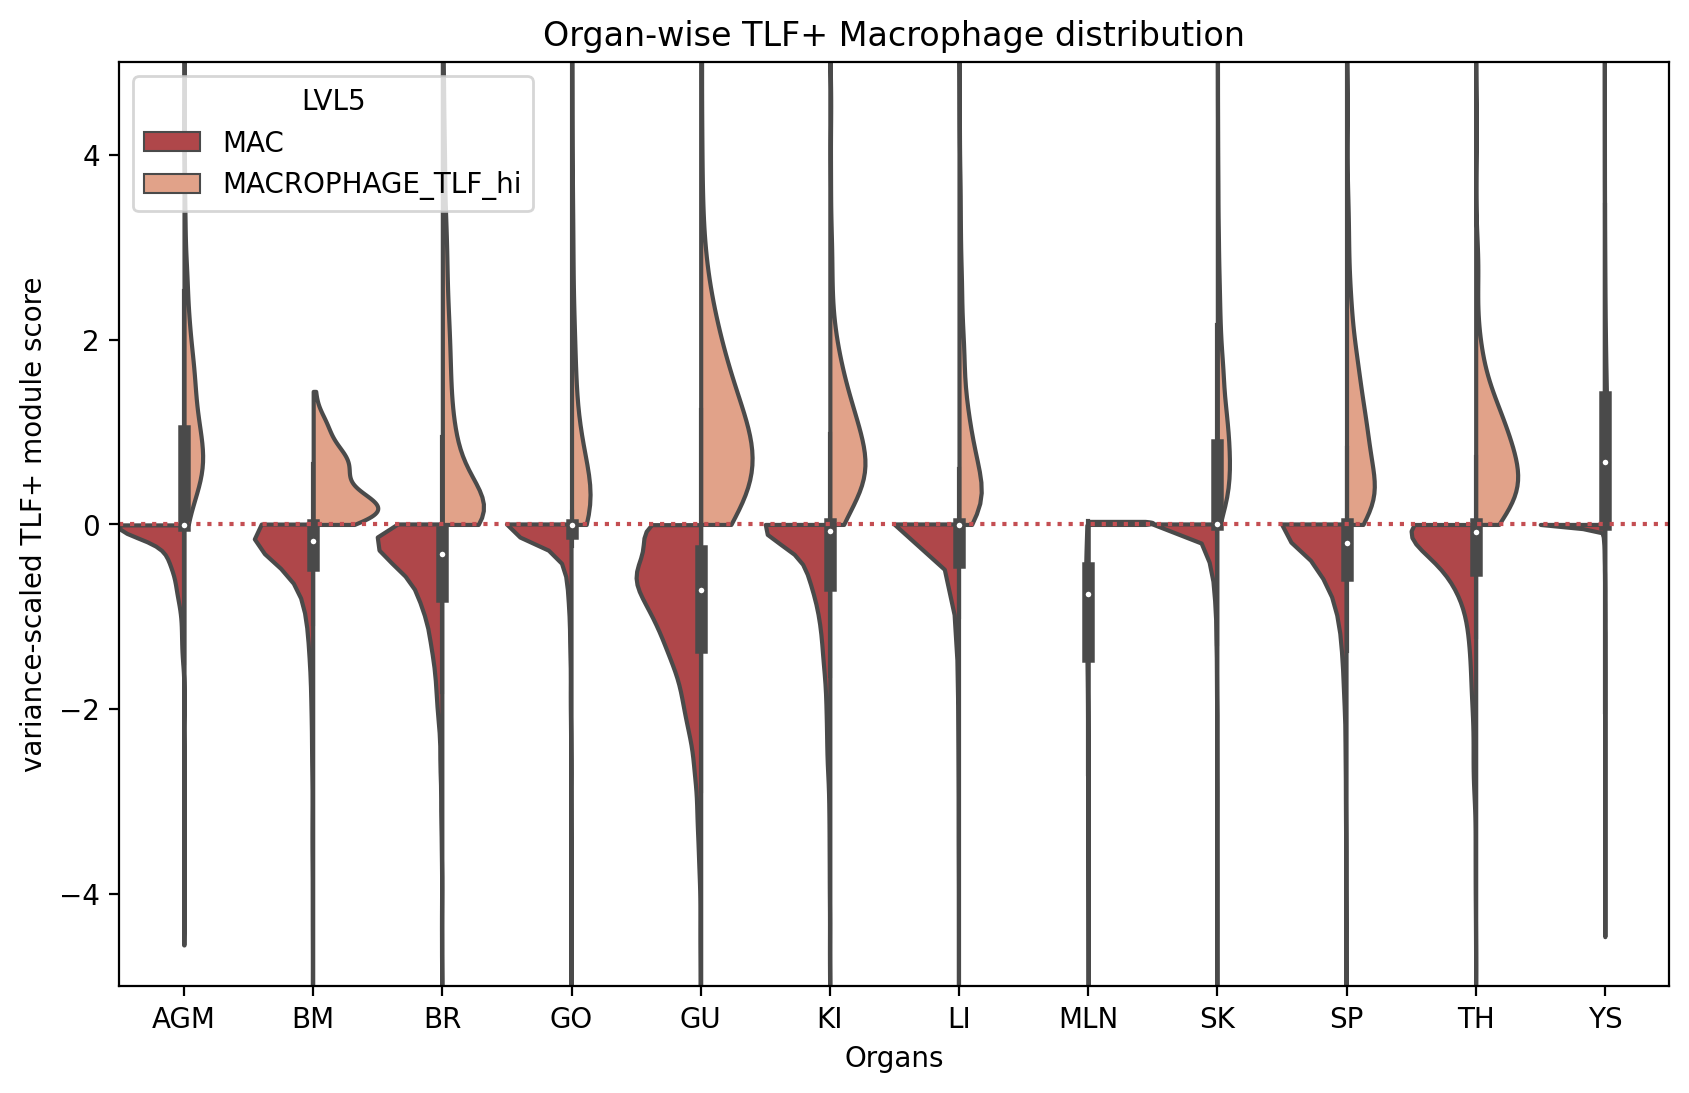

In [25]:
vmin = -5
vmax = 5
plt.rcdefaults()
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(10,6))
sns.set_palette("RdBu")
# sns.set_style("darkgrid")
sns.violinplot(x='organ', y='scaled_pre_agm_mac_score',hue = 'LVL5', data=data,split= True,size=5,width = 1, cut=0, inner='box')#palette = []
# sns.boxplot(data = data, x='organ', y='scaled_pre_agm_mac_score', hue='LVL5', color='white', width=0.3, boxprops={'zorder': 2})
#sns.stripplot(x='organ', y='scaled_pre_agm_mac_score', data=data,  palette =col_dict ,jitter=True, zorder=1,alpha=.8,size=1)

# sns.swarmplot(x='organ', y='min_max_pre_agm_mac_score', data=data, color="k", alpha=0.8)
plt.ylim([vmin, vmax])
plt.axhline(y = 0, color = 'r', linestyle = ':')#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])
plt.title("Organ-wise TLF+ Macrophage distribution")
plt.ylabel("variance-scaled TLF+ module score")
plt.xlabel("Organs")
plt.savefig(('./v6_Violin_organ_wise_tlf_distribution.pdf'),dpi=300,bbox_inches='tight')
plt.show()

# Order by magnitude

In [394]:
ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
for organ in ranker['organ'].unique():
    rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
rank_prop = rank_prop.sort_values('prop',ascending = False)
data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

# ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
# rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
# for organ in ranker['organ'].unique():
#     rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
# rank_prop = rank_prop.sort_values('prop',ascending = False)
# data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
# col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

<ipython-input-394-330fe0c74144>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.patches as mpatches

plt.rcdefaults()
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(15,10))

data = data
x = 'organ'
y = 'scaled_pre_agm_mac_score'
split = False#'LVL5'
save_name = './v6_2color_ordered_Violin_organ_wise_tlf_distribution.pdf'
vmin = -5
vmax = 5
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])
jitter = False
use_custom_color_dict = False

if use_custom_color_dict == False:
    sns.set_palette(palette = sns.color_palette())
    ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1, split_palette=True,cut=0,)#palette = []
    # add hatched legend
    circ1 = mpatches.Patch( facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),alpha=0.8,label='Mac')
    circ2 = mpatches.Patch( facecolor=(1.0, 0.4980392156862745, 0.054901960784313725),alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
else:
    ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1, split_palette=True,cut=0, palette=['.2', '.5'])#palette = []
    if jitter == True:
        ax = sns.stripplot(x=x, y=y, data=data_striplot,jitter=0.2, zorder=1,alpha=.5,size=1,color = 'grey')#,palette =col_dict ) #palette =col_dict 
    colors = list(col_dict.values()) + list(col_dict.values())
    handles = []
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
        violin.set_facecolor(rgb)
        handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))#hatch=r'\\\\')
        # set marker colors
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
        legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
        ax.add_artist(legend2)
        plt.setp(legend2.get_title())#,fontsize='small'
        # add hatched legend
        circ1 = mpatches.Patch( facecolor='#808080',alpha=0.8,label='Mac')
        circ2 = mpatches.Patch( facecolor='#808080',alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')

for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
    if i % 2:
        violin.set_hatch("//")
plt.ylim([vmin, vmax])        
# red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
#legend1 = plt.legend(handles=[tuple(handles[::2]), tuple(handles[1::2]),red_line], labels=data["LVL5"].cat.categories.to_list(),title="Pre-AGM mac module enriched", handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},bbox_to_anchor=(1.21, 1))

legend3 = plt.legend(handles=[circ1,circ2], numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.3))
#ax.add_artist(legend1)
ax.add_artist(legend3)

plt.axhline(y = 0, color = 'r', linestyle = ':')#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])#plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
plt.title("Organ-wise Pre-AGM YS Mac module distribution",fontsize = 20,y=1.05,fontweight='bold')
plt.ylabel("variance-scaled TLF+ module score",fontsize = 20,fontweight='bold')
plt.xlabel("Organs",fontsize = 20,fontweight='bold')
plt.savefig((save_name),dpi=300,bbox_inches='tight')
plt.show()

In [397]:

organs_ = ['TH','KI','BM','GU','LI','SP','MLN']
data.loc[data['scaled_pre_agm_mac_score']>7.5, 'scaled_pre_agm_mac_score'] = 7.5
data.loc[data['scaled_pre_agm_mac_score']<-6, 'scaled_pre_agm_mac_score'] = -6
for organ in organs_: #data['organ'].unique():#
    print(organ)
    # too large! convert any values >10 to 10
    data.loc[(data['organ'].isin([organ])) & (data['scaled_pre_agm_mac_score']>5), 'scaled_pre_agm_mac_score'] = np.percentile(data.loc[data['organ'].isin([organ]), 'scaled_pre_agm_mac_score'],99)
    data.loc[(data['organ'].isin([organ])) & (data['scaled_pre_agm_mac_score']<-7.5), 'scaled_pre_agm_mac_score'] = np.percentile(data.loc[data['organ'].isin([organ]), 'scaled_pre_agm_mac_score'],10)
for organ in data['organ'].unique():#
    print(organ)
    # too large! convert any values >10 to 10
    data.loc[(data['organ'].isin([organ])) & (data['scaled_pre_agm_mac_score']<-6), 'scaled_pre_agm_mac_score'] = np.percentile(data.loc[data['organ'].isin([organ]), 'scaled_pre_agm_mac_score'],10)

organs_ = ['KI','BM','GU','LI','SP']
for organ in organs_:
    data.loc[data['organ'].isin([organ]), 'scaled_pre_agm_mac_score'] = data.loc[data['organ'].isin([organ]), 'scaled_pre_agm_mac_score'] - 0.25

TH
KI
BM
GU
LI
SP
MLN
AGM
GO
BR
YS
MLN
KI
BM
GU
TH
LI
SP
SK


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


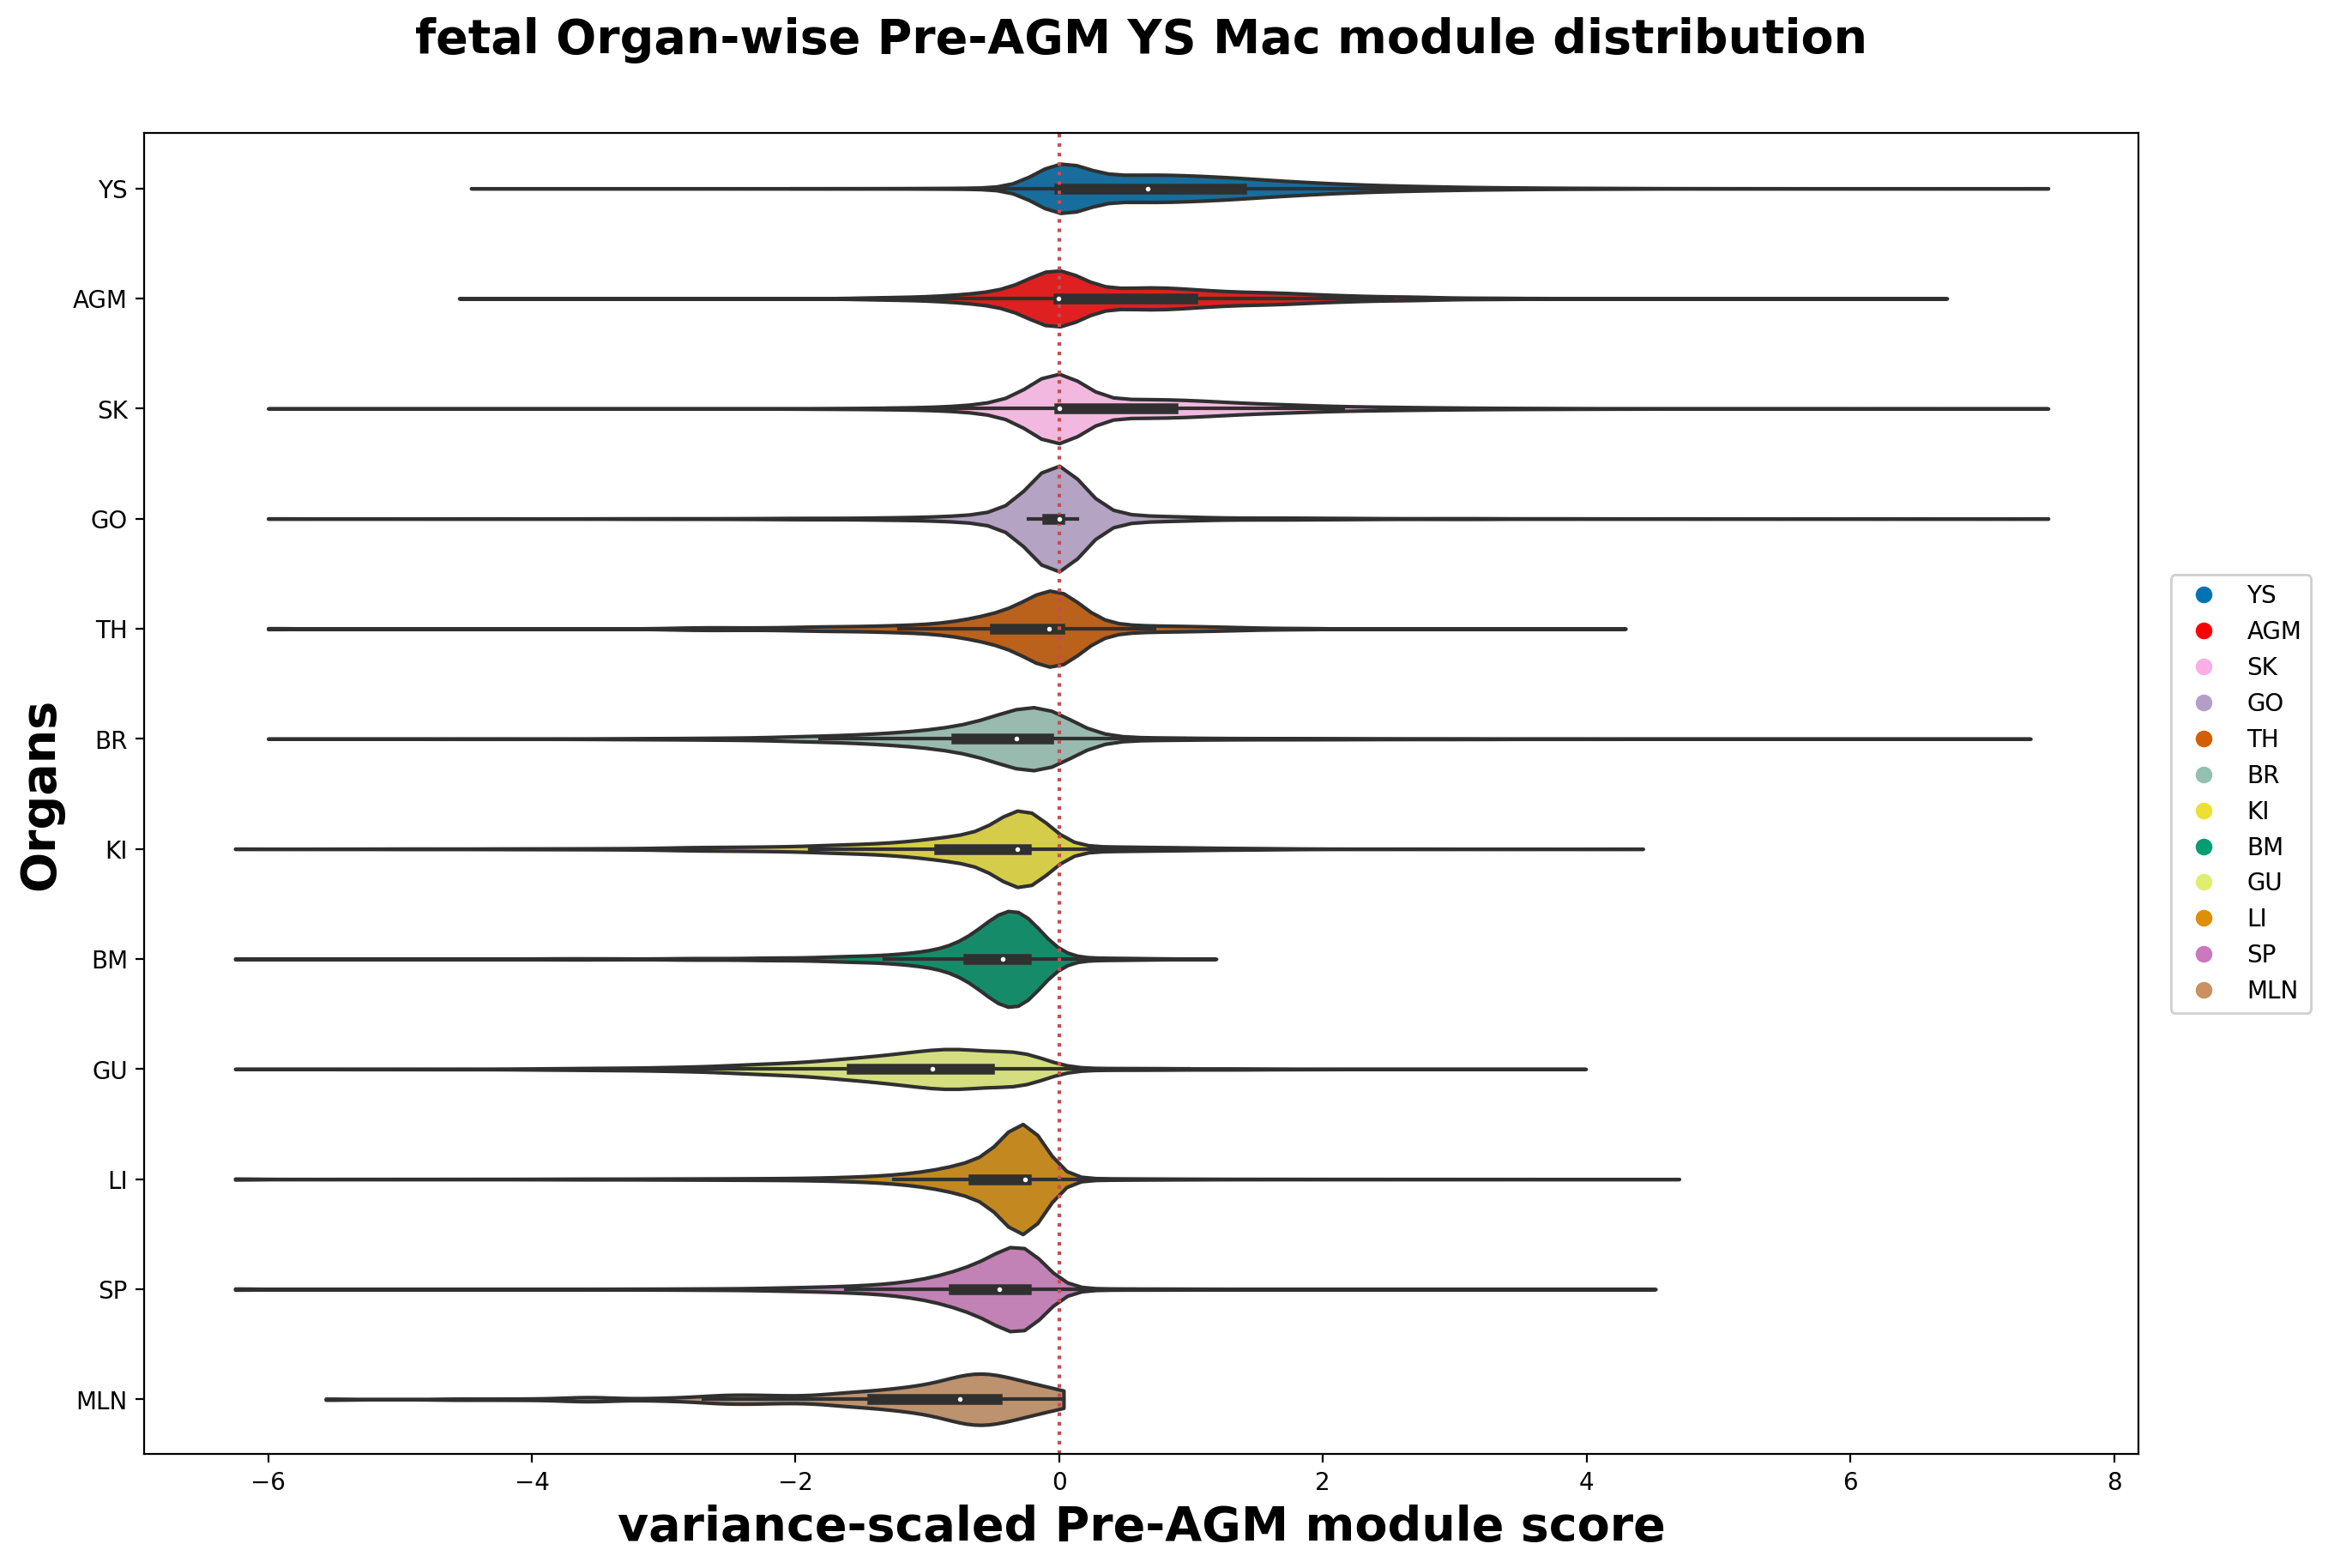

In [506]:
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.patches as mpatches

plt.rcdefaults()
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(15,10))

data = data
x = 'organ'
y = 'scaled_pre_agm_mac_score'
split = False #'LVL5'
save_name = './v6_2_colors_col_fetal_ordered_Violin_organ_wise_tlf_distribution.pdf'
vmin = -5
vmax = 5
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])
jitter = False
use_custom_color_dict = True


if use_custom_color_dict == False:
    sns.set_palette(palette = sns.color_palette())
    if split == False:
        ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2)#palette = []
    else:
        ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1.5, split_palette=True,cut=0,)#palette = []
        # add hatched legend
        circ1 = mpatches.Patch( facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),alpha=0.8,label='All Macs')
        circ2 = mpatches.Patch( facecolor=(1.0, 0.4980392156862745, 0.054901960784313725),alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
else:
    color_key = col_dict 
    if split == False:
        ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2, palette=col_dict)#palette = []
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
        legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
        ax.add_artist(legend2)
    else:
        ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1, split_palette=True,cut=0, palette=['.2', '.5'])#palette = []
        colors = list(col_dict.values()) + list(col_dict.values())
        handles = []
        for ind, violin in enumerate(ax.findobj(PolyCollection)):
            rgb = to_rgb(colors[ind // 2])
            if ind % 2 != 0:
                rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
            violin.set_facecolor(rgb)
            handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))#hatch=r'\\\\')
            # set marker colors
            markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
            legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
            ax.add_artist(legend2)
            plt.setp(legend2.get_title())#,fontsize='small'
            # add hatched legend
            circ1 = mpatches.Patch( facecolor='#808080',alpha=0.8,label='Mac')
            circ2 = mpatches.Patch( facecolor='#808080',alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
    if jitter == True:
        ax = sns.stripplot(x=x, y=y, data=data_striplot,jitter=0.2, zorder=1,alpha=.5,size=1,color = 'grey')#,palette =col_dict ) #palette =col_dict 

# for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     if i % 2:
#         violin.set_hatch("//")
# plt.ylim([vmin, vmax])        
# red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
#legend1 = plt.legend(handles=[tuple(handles[::2]), tuple(handles[1::2]),red_line], labels=data["LVL5"].cat.categories.to_list(),title="Pre-AGM mac module enriched", handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},bbox_to_anchor=(1.21, 1))

# legend3 = plt.legend(handles=[circ1], numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.3))#circ2
# #ax.add_artist(legend1)
# ax.add_artist(legend3)

plt.axvline(x = 0, color = 'r', linestyle = ':')#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])#plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
plt.title("fetal Organ-wise Pre-AGM YS Mac module distribution",fontsize = 20,y=1.05,fontweight='bold')
plt.xlabel("variance-scaled Pre-AGM module score",fontsize = 20,fontweight='bold')
plt.ylabel("Organs",fontsize = 20,fontweight='bold')
plt.savefig((save_name),dpi=300,bbox_inches='tight')
plt.show()

In [413]:
fig_sz = plt.gcf()
size = fig_sz.get_size_inches()
size[1]

4.8

<Figure size 640x480 with 0 Axes>

In [104]:
ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
for organ in ranker['organ'].unique():
    rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
rank_prop = rank_prop.sort_values('prop',ascending = False)
data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

# ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
# rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
# for organ in ranker['organ'].unique():
#     rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
# rank_prop = rank_prop.sort_values('prop',ascending = False)
# data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
# col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

<ipython-input-104-330fe0c74144>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))


<Figure size 640x480 with 0 Axes>

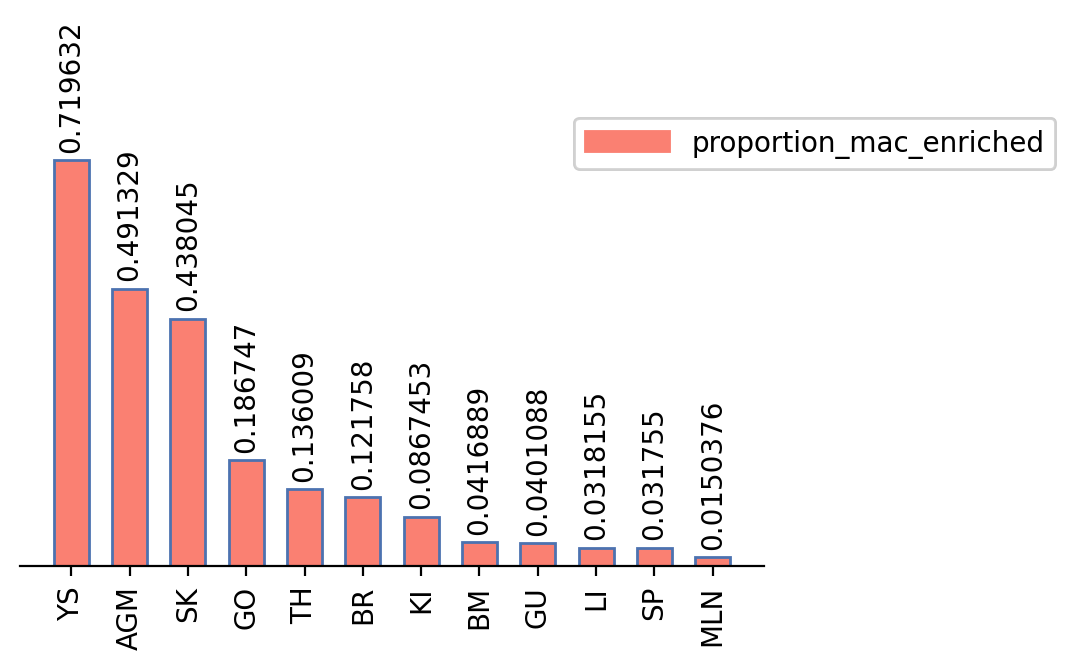

In [444]:
from matplotlib import rcParams
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
width = 0.6
fig_sz = plt.gcf()
size = fig_sz.get_size_inches()
counts = rank_prop
fig, ax = plt.subplots(figsize=(size[1],3),frameon=False)    
bars = ax.bar(x = counts.index, height = counts['prop'], width = width, bottom=None, align='center', data=None,color = '#FA8072', edgecolor='b')
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=90)
ax.set_ylim([0, max(counts['prop'])+0.1])
ax.bar_label(bars,fontsize=10,rotation=90,padding = 3)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

patch = mpatches.Patch(color='#FA8072', label='proportion_mac_enriched')
legend_1 = plt.legend(handles=[patch],bbox_to_anchor=(1.41, 1), handlelength=3)
ax.add_artist(legend_1)
plt.show()
fig.savefig('A1_V1_bars_fetal_mac_enrich_prop_main.pdf', bbox_inches = 'tight',dpi = 300)

In [416]:
col_dict

{'YS': '#0173b2',
 'AGM': '#ff0000',
 'SK': '#fbafe4',
 'GO': '#B49EC8',
 'TH': '#d55e00',
 'BR': '#94BFB1',
 'KI': '#ece133',
 'BM': '#029e73',
 'GU': '#E0EE70',
 'LI': '#de8f05',
 'SP': '#cc78bc',
 'MLN': '#ca9161'}

In [417]:
data['organ'].cat.categories

Index(['YS', 'AGM', 'SK', 'GO', 'TH', 'BR', 'KI', 'BM', 'GU', 'LI', 'SP',
       'MLN'],
      dtype='object')

In [418]:
data

organ  scaled_pre_agm_mac_score  \
AAATGCCTCAGGCGAA-0                AGM                 -0.004884   
AACCATGAGCCACTAT-0                AGM                 -0.004884   
AACGTTGAGTCCCACG-0                AGM                 -0.004884   
AACTCCCGTAATTGGA-0                AGM                  0.306603   
AACTCCCTCAAGATCC-0                AGM                  0.686830   
...                               ...                       ...   
FCAImmP7862096-CCATGTCAGGCGCTCT    SK                 -2.772084   
FCAImmP7862096-CTGCTGTCAATCCAAC    SK                 -2.285234   
FCAImmP7862096-CACATAGAGAACAATC    SK                  0.592755   
FCAImmP7862096-GTCTTCGTCATCGATG    SK                  1.118294   
FCAImmP7803042-TCTCATATCCTATGTT    SK                 -3.646280   

                                              LVL5      col  
AAATGCCTCAGGCGAA-0                             MAC  #ff0000  
AACCATGAGCCACTAT-0                             MAC  #ff0000  
AACGTTGAGTCCCACG-0                             MAC  #ff0000  
AACTCCCGTAATTGGA-0               MACROPHAGE_TLF_hi  #ff0000  
AACTCCCTCAAGATCC-0               MACROPHAGE_TLF_hi  #ff0000  
...                                            ...      ...  
FCAImmP7862096-CCATGTCAGGCGCTCT                MAC  #fbafe4  
FCAImmP7862096-CTGCTGTCAATCCAAC                MAC  #fbafe4  
FCAImmP7862096-CACATAGAGAACAATC  MACROPHAGE_TLF_hi  #fbafe4  
FCAImmP7862096-GTCTTCGTCATCGATG  MACROPHAGE_TLF_hi  #fbafe4  
FCAImmP7803042-TCTCATATCCTATGTT                MAC  #fbafe4  

[147858 rows x 4 columns]

# Plot Barplots for proportion enrichment in MACS

In [ ]:
ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
for organ in ranker['organ'].unique():
    rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
rank_prop = rank_prop.sort_values('prop',ascending = False)
data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

# ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
# rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
# for organ in ranker['organ'].unique():
#     rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
# rank_prop = rank_prop.sort_values('prop',ascending = False)
# data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
# col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

In [66]:
enr_rank = pd.DataFrame(adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi'])].groupby(['organ','LVL3']).apply(len)).reset_index()
enr_rank.columns = ['organ', 'LVL3','count']
enr_rank['organ'].astype('category').cat.reorder_categories(org_order)
prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})

prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count'] = prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count']**1/4
pcts = prop.copy()

# Change: groupby and divide by sum
prop_x = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})
pcts_x = prop_x.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
pcts_x = pcts_x.reset_index()

In [67]:
pcts_x

organ                       LVL3      count
0      YS             MACROPHAGE_ERY   0.000000
1      YS  MACROPHAGE_IRON_RECYCLING  47.447799
2      YS    MACROPHAGE_KUPFFER_LIKE  17.919378
3      YS      MACROPHAGE_LYVE1_HIGH  19.887117
4      YS      MACROPHAGE_MHCII_HIGH   0.000000
..    ...                        ...        ...
103   MLN      MACROPHAGE_MHCII_HIGH   0.000000
104   MLN       MACROPHAGE_MICROGLIA   0.000000
105   MLN            MACROPHAGE_PERI   0.000000
106   MLN         MACROPHAGE_PRE_MAC   0.000000
107   MLN   MACROPHAGE_PROLIFERATING   0.000000

[108 rows x 3 columns]

In [68]:
prop_x.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

count
organ LVL3                                
YS    MACROPHAGE_ERY              0.000000
      MACROPHAGE_IRON_RECYCLING  47.447799
      MACROPHAGE_KUPFFER_LIKE    17.919378
      MACROPHAGE_LYVE1_HIGH      19.887117
      MACROPHAGE_MHCII_HIGH       0.000000
...                                    ...
MLN   MACROPHAGE_MHCII_HIGH       0.000000
      MACROPHAGE_MICROGLIA        0.000000
      MACROPHAGE_PERI             0.000000
      MACROPHAGE_PRE_MAC          0.000000
      MACROPHAGE_PROLIFERATING    0.000000

[108 rows x 1 columns]

In [69]:
enr_rank = pd.DataFrame(adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi'])].groupby(['organ','LVL3']).apply(len)).reset_index()
enr_rank.columns = ['organ', 'LVL3','count']
enr_rank['organ'].astype('category').cat.reorder_categories(org_order)
prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})

prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count'] = prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count']**(1/4)
pcts = prop.copy()

# Change: groupby and divide by sum
prop_x = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})
pcts_x = prop_x.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
pcts_x = pcts_x.reset_index()
pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count']
pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count']

5      232.000000
7        9.000000
8     4540.000000
19      77.000000
20      79.000000
22       2.632148
23      14.000000
28      33.000000
29       5.000000
31       2.030543
36      10.000000
39      87.000000
40       2.672345
41       3.000000
45       2.000000
46      18.000000
47       5.000000
49       2.213364
50       5.000000
51      35.000000
53    1198.000000
55       1.000000
58       1.189207
59       1.000000
62      13.000000
63       1.000000
72       6.000000
73      72.000000
74       1.000000
76       1.414214
82       1.000000
83       7.000000
85       1.495349
89       8.000000
94       1.189207
95       1.000000
98       3.000000
Name: count, dtype: float64

In [70]:
sum((adata_plot.obs.loc[adata_plot.obs['organ'].isin(['YS'])].groupby(['LVL3']).apply(len)))

45055

In [71]:
pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'
pcts.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()

organ                       LVL3    count
0      YS             MACROPHAGE_ERY      0.0
1      YS  MACROPHAGE_IRON_RECYCLING  15384.0
2      YS    MACROPHAGE_KUPFFER_LIKE   5810.0
3      YS      MACROPHAGE_LYVE1_HIGH  11229.0
4      YS      MACROPHAGE_MHCII_HIGH      0.0
..    ...                        ...      ...
103   MLN      MACROPHAGE_MHCII_HIGH      0.0
104   MLN       MACROPHAGE_MICROGLIA      0.0
105   MLN            MACROPHAGE_PERI      0.0
106   MLN         MACROPHAGE_PRE_MAC      0.0
107   MLN   MACROPHAGE_PROLIFERATING      0.0

[108 rows x 3 columns]

In [72]:
list(adata_plot.obs.loc[adata_plot.obs['organ'].isin(['YS']),'LVL3'].unique())

['MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_PROLIFERATING',
 'MACROPHAGE_PRE_MAC',
 'MACROPHAGE_MICROGLIA']

In [73]:
adata_plot_orig = adata_plot[:]

In [92]:
adata_plot = adata_plot_orig[:]

In [93]:
list(adata_plot.obs['LVL3'].unique())

['MACROPHAGE_PROLIFERATING',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_PERI',
 'MACROPHAGE_ERY',
 'MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_PRE_MAC']

In [94]:
adata_plot.obs['LVL3'] = adata_plot.obs['LVL3'].astype(str)
adata_plot.obs.loc[(adata_plot.obs['organ'].isin(['YS'])) & (adata_plot.obs['LVL3'].isin(['MACROPHAGE_IRON_RECYCLING','MACROPHAGE_KUPFFER_LIKE','MACROPHAGE_LYVE1_HIGH',])),'LVL3'] = 'MACROPHAGE'
# adata_plot.obs.loc[ (adata_plot.obs['LVL3'].isin(['MACROPHAGE_IRON_RECYCLING','MACROPHAGE_KUPFFER_LIKE','MACROPHAGE_LYVE1_HIGH',])),'LVL3'] = 'MACROPHAGE'
enr_rank = pd.DataFrame(adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi'])].groupby(['organ','LVL3']).apply(len)).reset_index()
enr_rank.columns = ['organ', 'LVL3','count']
enr_rank['organ'].astype('category').cat.reorder_categories(org_order)
prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})

prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count'] = prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count']**(1/4)
pcts = prop.copy()

# Change: groupby and divide by sum
prop_x = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})
pcts_x = prop_x.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
pcts_x = pcts_x.reset_index()

#If prop <0.1, 10% of enriched population, remove or add to largest cat
#pcts.loc[pcts_x['count']<5,'count'] = 0
#pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'LVL_panimmune'] = 'MACROPHAGE_LYVE1_HIGH'
#pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] = pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] + pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count']
pcts.loc[(pcts_x['count']<5) & (pcts_x['count']>0),'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'
#Remove any less than 10 cells, must be minimum of 5 cells
pcts.loc[pcts['count']<5,'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'

pcts = pcts.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
# pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count'] = 0


# pcts['count'] = pcts['count']+1
#pcts['count'] = np.log10(pcts['count'])
pcts_mat = pcts.pivot(index = 'organ', columns = 'LVL3', values='count')
pcts_mat

<ipython-input-94-d5ad5c885972>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_plot.obs['LVL3'] = adata_plot.obs['LVL3'].astype(str)


LVL3   MACROPHAGE  MACROPHAGE_IRON_RECYCLING  MACROPHAGE_KUPFFER_LIKE  \
organ                                                                   
YS        27642.0                        0.0                      0.0   
BR            0.0                        0.0                      0.0   
GO            0.0                       77.0                     79.0   
AGM           0.0                       33.0                      0.0   
LI            0.0                      710.0                    331.0   
SK            0.0                        0.0                      0.0   
TH            0.0                        0.0                      0.0   
KI            0.0                        0.0                      0.0   
SP            0.0                       72.0                      0.0   
GU            0.0                        0.0                      7.0   
BM            0.0                        0.0                      0.0   
MLN           0.0                        0.0                      0.0   

LVL3   MACROPHAGE_LYVE1_HIGH  MACROPHAGE_MICROGLIA  MACROPHAGE_PROLIFERATING  
organ                                                                         
YS                241.000000                   0.0                    4540.0  
BR                185.000000                 653.0                     162.0  
GO                240.632148                   0.0                     178.0  
AGM               436.030543                 111.0                       0.0  
LI                102.672345                   0.0                     255.0  
SK               7519.213364                   0.0                    1198.0  
TH                108.189207                   0.0                      13.0  
KI                115.952592                   0.0                      61.0  
SP                335.414214                   0.0                      95.0  
GU                 99.495349                   0.0                       8.0  
BM                 77.189207                   0.0                       0.0  
MLN                 2.000000                   0.0                       0.0

In [77]:
pcts_mat.to_csv('pcts_mat.csv')

In [95]:
adata_plot.obs['LVL3'] = adata_plot.obs['LVL3'].astype(str)
adata_plot.obs.loc[(adata_plot.obs['organ'].isin(['YS'])) & (adata_plot.obs['LVL3'].isin(['MACROPHAGE_IRON_RECYCLING','MACROPHAGE_KUPFFER_LIKE','MACROPHAGE_LYVE1_HIGH',])),'LVL3'] = 'MACROPHAGE'
# adata_plot.obs.loc[ (adata_plot.obs['LVL3'].isin(['MACROPHAGE_IRON_RECYCLING','MACROPHAGE_KUPFFER_LIKE','MACROPHAGE_LYVE1_HIGH',])),'LVL3'] = 'MACROPHAGE'
enr_rank = pd.DataFrame(adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi'])].groupby(['organ','LVL3']).apply(len)).reset_index()
enr_rank.columns = ['organ', 'LVL3','count']
enr_rank['organ'].astype('category').cat.reorder_categories(org_order)
prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})

prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count'] = prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count']**(1/4)
pcts = prop.copy()

# Change: groupby and divide by sum
prop_x = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})
pcts_x = prop_x.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
pcts_x = pcts_x.reset_index()

#If prop <0.1, 10% of enriched population, remove or add to largest cat
#pcts.loc[pcts_x['count']<5,'count'] = 0
#pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'LVL_panimmune'] = 'MACROPHAGE_LYVE1_HIGH'
#pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] = pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] + pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count']
#pcts.loc[(pcts_x['count']<5) & (pcts_x['count']>0),'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'
#Remove any less than 10 cells, must be minimum of 5 cells
#pcts.loc[pcts['count']<5,'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'

pcts = pcts.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
# pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count'] = 0


# pcts['count'] = pcts['count']+1
#pcts['count'] = np.log10(pcts['count'])
pcts_mat = pcts.pivot(index = 'organ', columns = 'LVL3', values='count')
pcts_mat

LVL3   MACROPHAGE  MACROPHAGE_ERY  MACROPHAGE_IRON_RECYCLING  \
organ                                                          
YS        27642.0             0.0                        0.0   
BR            0.0             0.0                        0.0   
GO            0.0             0.0                       77.0   
AGM           0.0             0.0                       33.0   
LI            0.0            10.0                      710.0   
SK            0.0             2.0                       18.0   
TH            0.0             0.0                        1.0   
KI            0.0             1.0                        0.0   
SP            0.0             6.0                       72.0   
GU            0.0             0.0                        1.0   
BM            0.0             0.0                        0.0   
MLN           0.0             0.0                        0.0   

LVL3   MACROPHAGE_KUPFFER_LIKE  MACROPHAGE_LYVE1_HIGH  MACROPHAGE_MHCII_HIGH  \
organ                                                                          
YS                         0.0                    0.0               0.000000   
BR                         0.0                  185.0               0.000000   
GO                        79.0                  224.0               2.632148   
AGM                        5.0                  429.0               2.030543   
LI                       331.0                   87.0               2.672345   
SK                         5.0                 7452.0               2.213364   
TH                         0.0                  105.0               1.189207   
KI                         0.0                  112.0               2.952592   
SP                         1.0                  327.0               1.414214   
GU                         7.0                   97.0               1.495349   
BM                         0.0                   72.0               1.189207   
MLN                        0.0                    2.0               0.000000   

LVL3   MACROPHAGE_MICROGLIA  MACROPHAGE_PERI  MACROPHAGE_PRE_MAC  \
organ                                                              
YS                    232.0              0.0                 9.0   
BR                    653.0              0.0                 0.0   
GO                     14.0              0.0                 0.0   
AGM                   111.0              0.0                 0.0   
LI                      3.0              0.0                 0.0   
SK                      5.0             35.0                 0.0   
TH                      1.0              0.0                 0.0   
KI                      0.0              0.0                 0.0   
SP                      0.0              0.0                 0.0   
GU                      0.0              0.0                 0.0   
BM                      1.0              0.0                 0.0   
MLN                     0.0              0.0                 0.0   

LVL3   MACROPHAGE_PROLIFERATING  
organ                            
YS                       4540.0  
BR                        162.0  
GO                        178.0  
AGM                         0.0  
LI                        255.0  
SK                       1198.0  
TH                         13.0  
KI                         61.0  
SP                         95.0  
GU                          8.0  
BM                          3.0  
MLN                         0.0

In [121]:
# %pprint
display(list((pcts_mat.sum(axis = 1)).astype(int)))
[16207, 578, 8678, 572, 120, 1000, 173, 76, 113, 1386, 495, 2]

[16207, 578, 8678, 572, 120, 1000, 173, 76, 113, 1386, 495, 2]

[16207, 578, 8678, 572, 120, 1000, 173, 76, 113, 1386, 495, 2]

In [96]:
order = ['YS',  'AGM','SK', 'GO', 'TH', 'BR', 'KI','BM','GU', 'LI',    'SP',   'MLN']

In [97]:
pcts_mat = pcts_mat.loc[order]

In [98]:
pcts_mat[pcts_mat.index.isin(['BR','GO','AGM','LI'])] = pcts_mat[pcts_mat.index.isin(['BR','GO','AGM','LI'])]

In [99]:
pcts_mat[pcts_mat.index.isin(['YS'])] = pcts_mat[pcts_mat.index.isin(['YS'])]/2

In [100]:
pcts_mat = pcts_mat[[
'MACROPHAGE',
'MACROPHAGE_MICROGLIA',
'MACROPHAGE_PROLIFERATING',
'MACROPHAGE_LYVE1_HIGH',
'MACROPHAGE_IRON_RECYCLING',
'MACROPHAGE_KUPFFER_LIKE',
]]

In [102]:
pcts_mat.columns = ['MACROPHAGE',
'MACROPHAGE_TREM2',
'MACROPHAGE_PROLIFERATING','MACROPHAGE_LYVE1_HIGH',
'MACROPHAGE_IRON_RECYCLING',
'MACROPHAGE_KUPFFER_LIKE',]

<Figure size 640x480 with 0 Axes>

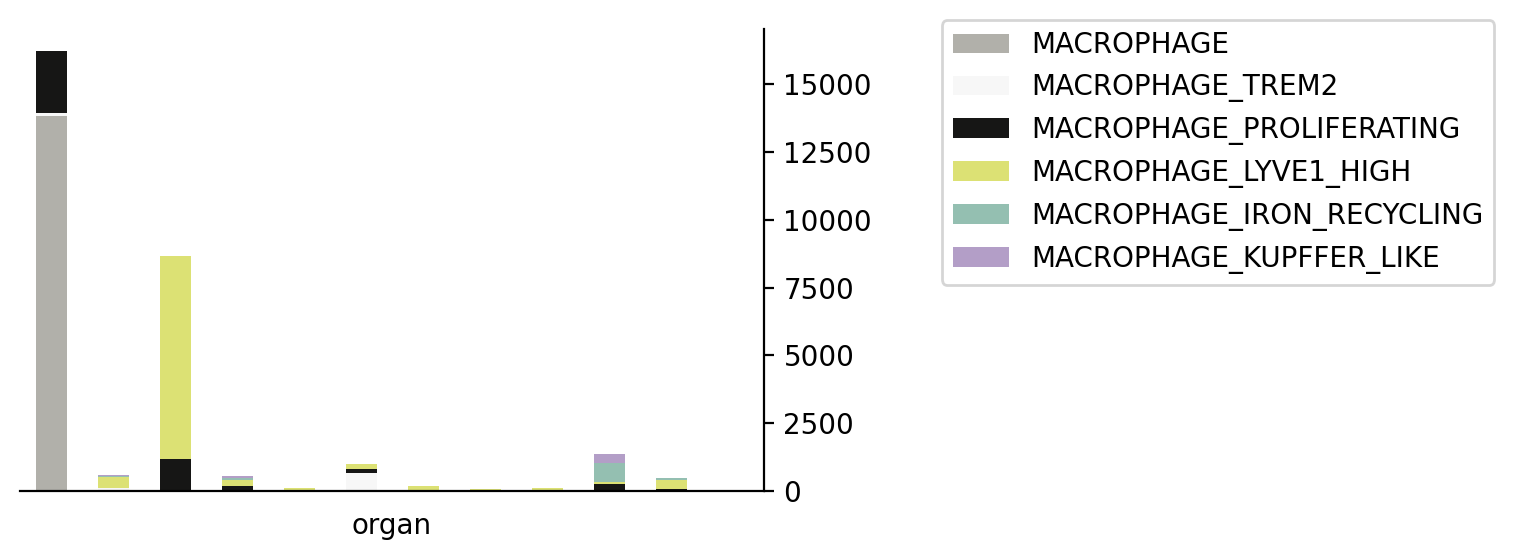

In [109]:
from matplotlib import rcParams
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
width = 0.6
fig_sz = plt.gcf()
size = fig_sz.get_size_inches()
counts = rank_prop
fig, ax = plt.subplots(figsize=(size[1],3),frameon=False)   

col_pal = ['#B1B0AA' ,'#F7F7F7','#161615','#DCE174','#94BFB1','#B39EC7']#['#ff0000','#94BFB1',     '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#A86458',    "#FFFF00"]
pcts_mat.plot.bar(rot=0,stacked = True,color = col_pal,ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=0)
# ax.set_ylim([0, max(counts['prop'])+0.1])
# ax.bar_label(bars,fontsize=10,rotation=90,padding = 3)
ax.yaxis.tick_right()
# ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.legend(bbox_to_anchor=(2, 1.05))
plt.savefig('./bars_count_enriched.pdf')
plt.show()

<Figure size 640x480 with 0 Axes>

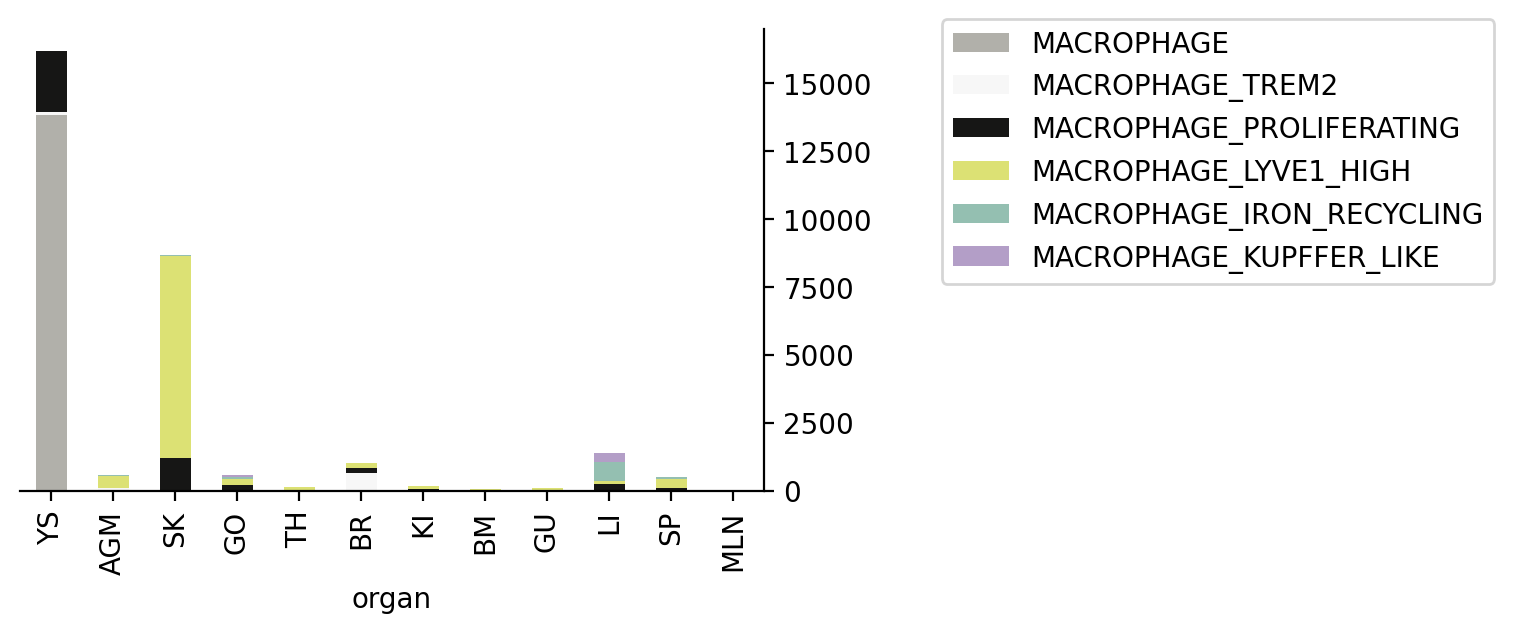

In [108]:
from matplotlib import rcParams
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
width = 0.6
fig_sz = plt.gcf()
size = fig_sz.get_size_inches()
counts = rank_prop
fig, ax = plt.subplots(figsize=(size[1],3),frameon=False)   

col_pal = ['#B1B0AA' ,'#F7F7F7','#161615','#DCE174','#94BFB1','#B39EC7']#col_pal = ['#ff0000','#94BFB1',     '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#A86458',    "#FFFF00"]
pcts_mat.plot.bar(rot=0,stacked = True,color = col_pal,ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=0)
# ax.set_ylim([0, max(counts['prop'])+0.1])
# ax.bar_label(bars,fontsize=10,rotation=90,padding = 3)
ax.yaxis.tick_right()
# ax.set_yticks([])
# ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.legend(bbox_to_anchor=(2, 1.05))
plt.savefig('./bars_count_enriched_with_x.pdf')
plt.show()

In [ ]:
from matplotlib import rcParams
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
width = 0.6
fig_sz = plt.gcf()
size = fig_sz.get_size_inches()
counts = rank_prop
fig, ax = plt.subplots(figsize=(size[1],3),frameon=False)   

col_pal = ['#ff0000','#94BFB1',     '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#A86458',    "#FFFF00"]
pcts_mat.plot.bar(rot=0,stacked = True,color = col_pal,ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=0)
# ax.set_ylim([0, max(counts['prop'])+0.1])
# ax.bar_label(bars,fontsize=10,rotation=90,padding = 3)
ax.yaxis.tick_right()
# ax.set_yticks([])
# ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.legend(bbox_to_anchor=(2, 1.05))
plt.savefig('./bars_count_enriched_with_x.pdf')
plt.show()

# as perctange instead of counts

In [50]:
enr_rank = pd.DataFrame(adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi'])].groupby(['organ','LVL3']).apply(len)).reset_index()
enr_rank.columns = ['organ', 'LVL3','count']
enr_rank['organ'].astype('category').cat.reorder_categories(org_order)
prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})

prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count'] = prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count']**(1/4)
pcts = prop.copy()

# Change: groupby and divide by sum
prop_x = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})
pcts_x = prop_x.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
pcts_x = pcts_x.reset_index()

#If prop <0.1, 10% of enriched population, remove or add to largest cat
#pcts.loc[pcts_x['count']<5,'count'] = 0
#pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'LVL_panimmune'] = 'MACROPHAGE_LYVE1_HIGH'
#pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] = pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] + pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count']
pcts.loc[(pcts_x['count']<5) & (pcts_x['count']>0),'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'
#Remove any less than 10 cells, must be minimum of 5 cells
pcts.loc[pcts['count']<5,'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'

pcts = pcts.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
# pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count'] = 0


# pcts['count'] = pcts['count']+1
#pcts['count'] = np.log10(pcts['count'])
pcts_mat = pcts.pivot(index = 'organ', columns = 'LVL3', values='count')
pcts_mat = ((pcts_mat.T/pcts_mat.T.sum())*100).T

In [55]:
pcts_mat

LVL3   MACROPHAGE_ERY  MACROPHAGE_IRON_RECYCLING  MACROPHAGE_KUPFFER_LIKE  \
organ                                                                       
YS                0.0                  47.447799                17.919378   
BR                0.0                   0.000000                 0.000000   
GO                0.0                  13.399877                13.747926   
AGM               0.0                   5.689356                 0.000000   
LI                0.0                  50.762425                23.665300   
SK                0.0                   0.000000                 0.000000   
TH                0.0                   0.000000                 0.000000   
KI                0.0                   0.000000                 0.000000   
SP                0.0                  14.330805                 0.000000   
GU                0.0                   0.000000                 6.113785   
BM                0.0                   0.000000                 0.000000   
MLN               0.0                   0.000000                 0.000000   

LVL3   MACROPHAGE_LYVE1_HIGH  MACROPHAGE_MHCII_HIGH  MACROPHAGE_MICROGLIA  \
organ                                                                       
YS                 20.630417                    0.0              0.000000   
BR                 18.500000                    0.0             65.300000   
GO                 41.875859                    0.0              0.000000   
AGM                75.173721                    0.0             19.136923   
LI                  7.340700                    0.0              0.000000   
SK                 86.257076                    0.0              0.000000   
TH                 89.272972                    0.0              0.000000   
KI                 65.527490                    0.0              0.000000   
SP                 66.760495                    0.0              0.000000   
GU                 86.899031                    0.0              0.000000   
BM                100.000000                    0.0              0.000000   
MLN               100.000000                    0.0              0.000000   

LVL3   MACROPHAGE_PERI  MACROPHAGE_PRE_MAC  MACROPHAGE_PROLIFERATING  
organ                                                                 
YS                 0.0                 0.0                 14.002406  
BR                 0.0                 0.0                 16.200000  
GO                 0.0                 0.0                 30.976339  
AGM                0.0                 0.0                  0.000000  
LI                 0.0                 0.0                 18.231575  
SK                 0.0                 0.0                 13.742924  
TH                 0.0                 0.0                 10.727028  
KI                 0.0                 0.0                 34.472510  
SP                 0.0                 0.0                 18.908701  
GU                 0.0                 0.0                  6.987183  
BM                 0.0                 0.0                  0.000000  
MLN                0.0                 0.0                  0.000000

<Figure size 640x480 with 0 Axes>

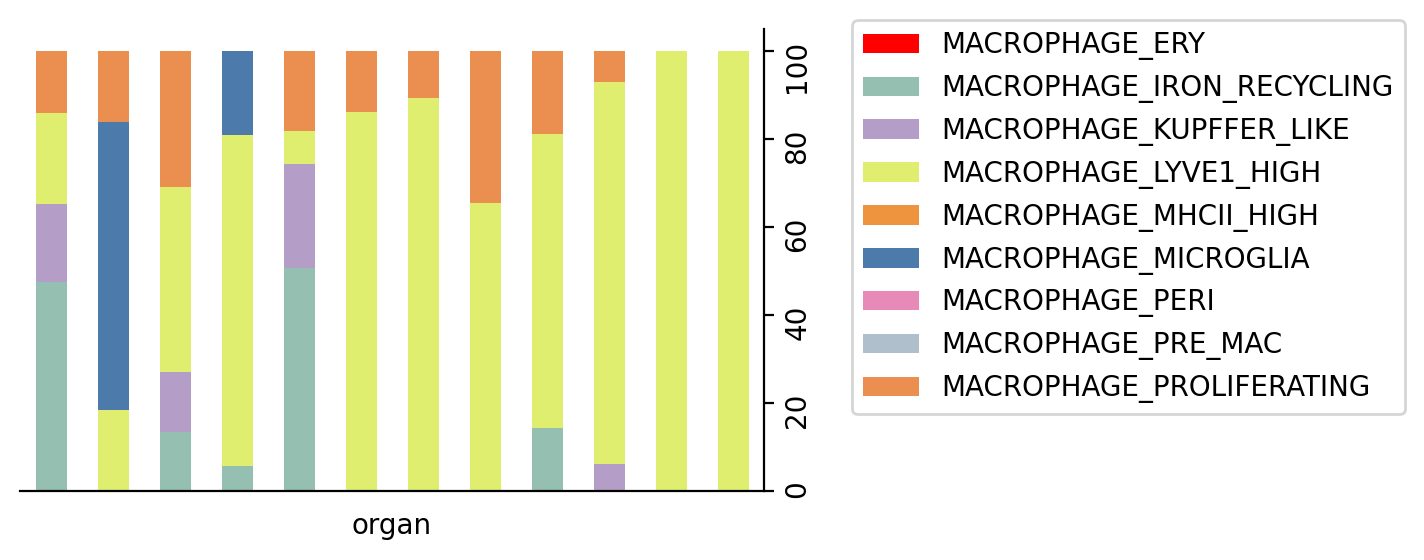

In [53]:
from matplotlib import rcParams
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
width = 0.6
fig_sz = plt.gcf()
size = fig_sz.get_size_inches()
counts = rank_prop
fig, ax = plt.subplots(figsize=(size[1],3),frameon=False)   

col_pal = ['#ff0000','#94BFB1',     '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#EB8F50',    "#EB8F50"]
pcts_mat.plot.bar(rot=0,stacked = True,color = col_pal,ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=90)
# ax.set_ylim([0, max(counts['prop'])+0.1])
# ax.bar_label(bars,fontsize=10,rotation=90,padding = 3)
ax.yaxis.tick_right()
# ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('./fetal_pecentage_bars_count_enriched.pdf')
plt.show()

<Figure size 640x480 with 0 Axes>

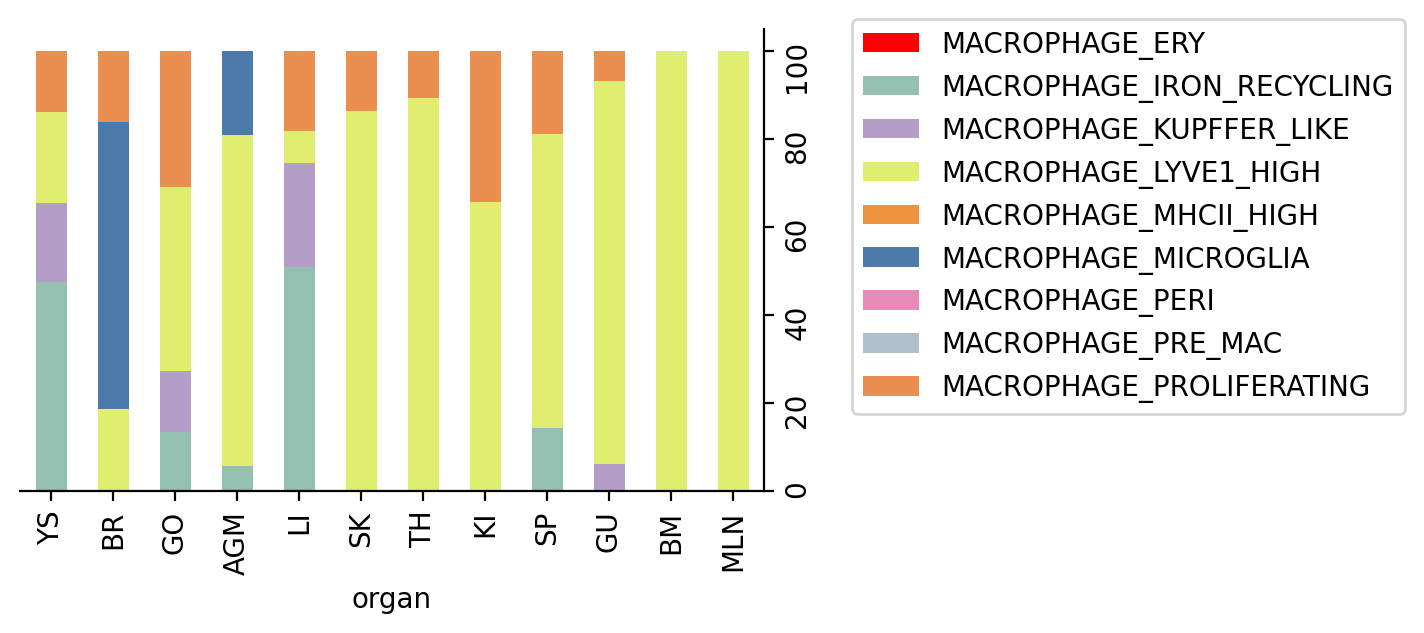

In [54]:
from matplotlib import rcParams
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
width = 0.6
fig_sz = plt.gcf()
size = fig_sz.get_size_inches()
counts = rank_prop
fig, ax = plt.subplots(figsize=(size[1],3),frameon=False)   

col_pal = ['#ff0000','#94BFB1',     '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#EB8F50',    "#FFFF00"]
pcts_mat.plot.bar(rot=0,stacked = True,color = col_pal,ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=90)
# ax.set_ylim([0, max(counts['prop'])+0.1])
# ax.bar_label(bars,fontsize=10,rotation=90,padding = 3)
ax.yaxis.tick_right()
# ax.set_yticks([])
# ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('./fetal_pecentage_bars_with_x_count_enriched.pdf', bbox_inches = 'tight')
plt.show()

In [421]:
# from matplotlib import pyplot as plt
# from matplotlib.colors import to_rgb
# from matplotlib.collections import PolyCollection
# from matplotlib.legend_handler import HandlerTuple
# import seaborn as sns
# import numpy as np
# from matplotlib.lines import Line2D
# import matplotlib as mpl
# import matplotlib.patches as mpatches

# plt.rcdefaults()
# plt.rcParams['figure.facecolor'] = 'white'
# plt.figure(figsize=(15,10))

# data = data
# x = 'organ'
# y = 'scaled_pre_agm_mac_score'
# split  = False #'LVL5'
# save_name = './v6_2_colors_col_fetal_ordered_Violin_organ_wise_tlf_distribution.pdf'
# vmin = -5
# vmax = 5
# col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])
# jitter = False
# use_custom_color_dict = True


# if use_custom_color_dict == False:
#     sns.set_palette(palette = sns.color_palette())
#     if split == False:
#         ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2)#palette = []
#     else:
#         ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1.5, split_palette=True,cut=0,)#palette = []
#         # add hatched legend
#         circ1 = mpatches.Patch( facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),alpha=0.8,label='All Macs')
#         circ2 = mpatches.Patch( facecolor=(1.0, 0.4980392156862745, 0.054901960784313725),alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
# else:
#     color_key = col_dict 
#     if split == False:
#         ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2, palette=col_dict)#palette = []
#         markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#         legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#         ax.add_artist(legend2)
#     else:
#         ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1, split_palette=True,cut=0, palette=['.2', '.5'])#palette = []
#         colors = list(col_dict.values()) + list(col_dict.values())
#         handles = []
#         for ind, violin in enumerate(ax.findobj(PolyCollection)):
#             rgb = to_rgb(colors[ind // 2])
#             if ind % 2 != 0:
#                 rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
#             violin.set_facecolor(rgb)
#             handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))#hatch=r'\\\\')
#             # set marker colors
#             markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#             legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#             ax.add_artist(legend2)
#             plt.setp(legend2.get_title())#,fontsize='small'
#             # add hatched legend
#             circ1 = mpatches.Patch( facecolor='#808080',alpha=0.8,label='Mac')
#             circ2 = mpatches.Patch( facecolor='#808080',alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
#     if jitter == True:
#         ax = sns.stripplot(x=x, y=y, data=data_striplot,jitter=0.2, zorder=1,alpha=.5,size=1,color = 'grey')#,palette =col_dict ) #palette =col_dict 

# # for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
# #     if i % 2:
# #         violin.set_hatch("//")
# plt.ylim([vmin, vmax])    
# # red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
# #legend1 = plt.legend(handles=[tuple(handles[::2]), tuple(handles[1::2]),red_line], labels=data["LVL5"].cat.categories.to_list(),title="Pre-AGM mac module enriched", handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},bbox_to_anchor=(1.21, 1))

# legend3 = plt.legend(handles=[circ1], numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.3))#circ2
# #ax.add_artist(legend1)
# ax.add_artist(legend3)

# plt.axvline(x = 0, color = 'r', linestyle = ':')#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])#plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
# plt.title("FETAL Organ-wise Pre-AGM YS Mac module distribution",fontsize = 20,y=1.05,fontweight='bold')
# plt.xlabel("variance-scaled Pre-AGM module score",fontsize = 20,fontweight='bold')
# plt.ylabel("Organs",fontsize = 20,fontweight='bold')
# plt.savefig((save_name),dpi=300,bbox_inches='tight')
# plt.show()

# plot a stacked violin graph for cellstates in each organ per row

In [422]:
# from matplotlib import pyplot as plt
# from matplotlib.colors import to_rgb
# from matplotlib.collections import PolyCollection
# from matplotlib.legend_handler import HandlerTuple
# import seaborn as sns
# import numpy as np
# from matplotlib.lines import Line2D
# import matplotlib as mpl
# import matplotlib.patches as mpatches

# plt.rcdefaults()
# plt.rcParams['figure.facecolor'] = 'white'
# plt.figure(figsize=(15,10))

# data = data
# x = 'organ'
# y = 'scaled_pre_agm_mac_score'
# split  = 'LVL5'
# save_name = './v6_2_colors_col_fetal_ordered_Violin_organ_wise_tlf_distribution.pdf'
# vmin = -5
# vmax = 5
# col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])
# jitter = False
# use_custom_color_dict = True


# if use_custom_color_dict == False:
#     sns.set_palette(palette = sns.color_palette())
#     if split == False:
#         ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2)#palette = []
#     else:
#         ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1.5, split_palette=True,cut=0,)#palette = []
#         # add hatched legend
#         circ1 = mpatches.Patch( facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),alpha=0.8,label='All Macs')
#         circ2 = mpatches.Patch( facecolor=(1.0, 0.4980392156862745, 0.054901960784313725),alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
# else:
#     color_key = col_dict 
#     if split == False:
#         ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2, palette=col_dict)#palette = []
#         markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#         legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#         ax.add_artist(legend2)
#     else:
#         ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1, split_palette=True,cut=0, palette=['.2', '.5'])#palette = []
#         colors = list(col_dict.values()) + list(col_dict.values())
#         handles = []
#         for ind, violin in enumerate(ax.findobj(PolyCollection)):
#             rgb = to_rgb(colors[ind // 2])
#             if ind % 2 != 0:
#                 rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
#             violin.set_facecolor(rgb)
#             handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))#hatch=r'\\\\')
#             # set marker colors
#             markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#             legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#             ax.add_artist(legend2)
#             plt.setp(legend2.get_title())#,fontsize='small'
#             # add hatched legend
#             circ1 = mpatches.Patch( facecolor='#808080',alpha=0.8,label='Mac')
#             circ2 = mpatches.Patch( facecolor='#808080',alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
#     if jitter == True:
#         ax = sns.stripplot(x=x, y=y, data=data_striplot,jitter=0.2, zorder=1,alpha=.5,size=1,color = 'grey')#,palette =col_dict ) #palette =col_dict 

# # for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
# #     if i % 2:
# #         violin.set_hatch("//")
# # plt.ylim([vmin, vmax])        
# # red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
# #legend1 = plt.legend(handles=[tuple(handles[::2]), tuple(handles[1::2]),red_line], labels=data["LVL5"].cat.categories.to_list(),title="Pre-AGM mac module enriched", handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},bbox_to_anchor=(1.21, 1))

# legend3 = plt.legend(handles=[circ1], numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.3))#circ2
# #ax.add_artist(legend1)
# ax.add_artist(legend3)

# plt.axvline(x = 0, color = 'r', linestyle = ':')#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])#plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
# plt.title("FETAL Organ-wise Pre-AGM YS Mac module distribution",fontsize = 20,y=1.05,fontweight='bold')
# plt.xlabel("variance-scaled Pre-AGM module score",fontsize = 20,fontweight='bold')
# plt.ylabel("Organs",fontsize = 20,fontweight='bold')
# plt.savefig((save_name),dpi=300,bbox_inches='tight')
# plt.show()

# plot a barplot for proportion of enriched cells


In [429]:
# # V3 let's use modified Z score instead
# from scipy.stats import median_abs_deviation as MAD
# adata_macs.obs['scaled_pre_agm_mac_score'] = 0
# score_style = 'min_tresh'#,'Mean' #'Mean', 'MAD','min_tresh' #enrich_mean
# scale = 'organ'
# if scale == 'all':
#     adata_macs.obs['transformed_pre_agm_mac_score'] =  np.log(adata_macs.obs['pre_agm_mac_score'] - np.min(adata_macs.obs['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score'] #
#     # Scale around the mean for TLF socre per organ
#     if score_style == 'MAD':
#         print('MAD')
#         adata_macs.obs['scaled_pre_agm_mac_score'] = ((adata_macs.obs['transformed_pre_agm_mac_score']-np.median(adata_macs.obs['transformed_pre_agm_mac_score'])))/MAD(adata_macs.obs['transformed_pre_agm_mac_score'])
#     elif score_style == 'min_tresh':
#         print('min_tresh')
#         adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-min(adata_macs.obs.loc[adata_macs.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score']))/np.std(adata_macs.obs['transformed_pre_agm_mac_score'])
#     else:
#         print('mean')
#         adata_macs.obs['scaled_pre_agm_mac_score'] = (adata_macs.obs['transformed_pre_agm_mac_score']-np.mean(adata_macs.obs['transformed_pre_agm_mac_score']))/np.std(adata_macs.obs['transformed_pre_agm_mac_score'])
#  #    adata_macs.obs.loc[adata_macs.obs['organ'].isin([organ]),['transformed_pre_agm_mac_score','scaled_pre_agm_mac_score','min_max_pre_agm_mac_score']] = organ_temp[['transformed_pre_agm_mac_score','scaled_pre_agm_mac_score','min_max_pre_agm_mac_score']] 

# if scale == 'organ': 
#     concat = pd.DataFrame(columns = adata_macs.obs.columns)
#     for organ in adata_macs.obs['organ'].unique():
#         print(organ)
#         organ_temp = adata_macs.obs[adata_macs.obs['organ'].isin([organ])]
#         organ_temp['transformed_pre_agm_mac_score'] =  np.log(adata_macs.obs['pre_agm_mac_score'] - np.min(adata_macs.obs['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score']#np.log(organ_temp['pre_agm_mac_score'] - np.min(organ_temp['pre_agm_mac_score']) + 1)#organ_temp['pre_agm_mac_score'] #
#         # Scale around the mean for TLF socre per organ
#         if score_style == 'MAD':
#             print('MAD')
#             organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['transformed_pre_agm_mac_score']-np.median(organ_temp['transformed_pre_agm_mac_score'])))/MAD(organ_temp['transformed_pre_agm_mac_score'])
#         elif score_style == 'min_tresh':
#             print('min_tresh')
#             organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['transformed_pre_agm_mac_score']-np.min(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score']))/np.std(organ_temp['transformed_pre_agm_mac_score'])) #min(adata_macs.obs.loc[adata_macs.obs['LVL5'].isin(['MACROPHAGE_pre_agm_hi']),'transformed_pre_agm_mac_score']))                                            
#         elif score_style == 'enrich_mean':
#             print('enrich_mean')
#             # new module scale by mean of just the enriched population
#             organ_temp['scaled_pre_agm_mac_score'] = ((organ_temp['transformed_pre_agm_mac_score']-np.mean(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score']))/np.std(organ_temp.loc[organ_temp['LVL5'].isin(['MACROPHAGE_TLF_hi']),'transformed_pre_agm_mac_score'])) #min(adata_macs.obs.loc[adata_macs.obs['LVL5'].isin(['MACROPHAGE_pre_agm_hi']),'transformed_pre_agm_mac_score']))
#         else:
#             print('mean')
#             organ_temp['scaled_pre_agm_mac_score'] = (organ_temp['transformed_pre_agm_mac_score']-np.mean(organ_temp['transformed_pre_agm_mac_score']))/np.std(organ_temp['transformed_pre_agm_mac_score'])
#         adata_macs.obs.loc[adata_macs.obs.index.isin(organ_temp.index),'scaled_pre_agm_mac_score'] = organ_temp['scaled_pre_agm_mac_score']
#         concat = pd.concat([organ_temp,concat])

In [424]:
# adata_plot = adata_macs[:]

In [425]:
# org_order = ['YS', 'BR', 'GO','AGM', 'LI', 'SK', 'TH', 'KI', 'SP', 'GU', 'BM', 'MLN']
# adata_plot.obs['organ'] = adata_plot.obs['organ'].astype('category').cat.reorder_categories(org_order)

<ipython-input-425-e4a10860aeae>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_plot.obs['organ'] = adata_plot.obs['organ'].astype('category').cat.reorder_categories(org_order)


In [430]:
# adata_plot.obs['LVL5']
# adata_plot.obs['LVL6'] = adata_plot.obs['organ'].astype(str)
# adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL6'] = adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi']),'LVL5']

### new cell-type_col dict

In [428]:
# cell_col_dict = {
# 'MACROPHAGE_TLF_hi':'#65B879',
# 'MACROPHAGE_IRON_RECYCLING':'#85B5A3',
# 'MACROPHAGE_KUPFFER_LIKE':'#A08FB3',
# 'MACROPHAGE_LYVE1_HIGH':'#CEDE78',
# 'MACROPHAGE_PRE_MAC':'#9EAFB7',
# 'MACROPHAGE_PROLIFERATING':'#EB8F50',
# 'MACROPHAGE_MICROGLIA':'#4C7397',
# 'MACROPHAGE_MHCII_HIGH':'#E38C4C',
# 'MACROPHAGE_PERI':'#D87FAA',
# 'MACROPHAGE_ERY':'#DB3432',
# }
# adata_plot.obs['LVL4'] = adata_plot.obs['LVL4'].cat.reorder_categories(list(cell_col_dict.keys()))
# data = concat[['organ','scaled_pre_agm_mac_score','LVL3','LVL4','LVL5']]
# data['LVL4'] = data['LVL4'].cat.reorder_categories(list(cell_col_dict.keys()))
# data['col'] = data['LVL4'].map(cell_col_dict)
# data['organ'] = data['organ'].astype('category').cat.reorder_categories(['YS', 'AGM', 'SK', 'GO', 'TH', 'BR', 'KI', 'BM', 'GU', 'LI', 'SP','MLN'])
# data

In [427]:
# loop through and plot for each organ
# plt_col_dict = {
# 'MACROPHAGE_IRON_RECYCLING':'#85B5A3',
# 'MACROPHAGE_KUPFFER_LIKE':'#A08FB3',
# 'MACROPHAGE_LYVE1_HIGH':'#CEDE78',
# 'MACROPHAGE_PRE_MAC':'#9EAFB7',
# 'MACROPHAGE_PROLIFERATING':'#EB8F50',
# 'MACROPHAGE_MICROGLIA':'#4C7397',
# 'MACROPHAGE_MHCII_HIGH':'#E38C4C',
# 'MACROPHAGE_PERI':'#D87FAA',
# 'MACROPHAGE_ERY':'#DB3432',
# }

In [426]:
# from matplotlib import pyplot as plt
# from matplotlib.colors import to_rgb
# from matplotlib.collections import PolyCollection
# from matplotlib.legend_handler import HandlerTuple
# import seaborn as sns
# import numpy as np
# from matplotlib.lines import Line2D
# import matplotlib as mpl
# import matplotlib.patches as mpatches

# for organ in list(data['organ'].cat.categories): #['LI']:
#     print(organ)
#     plt.rcdefaults()
#     plt.rcParams['figure.facecolor'] = 'white'
#     plt.figure(figsize=(10,3))

#     data = data_orig[data_orig['organ'].isin([organ])]
#     x = 'LVL3'
#     y = 'scaled_pre_agm_mac_score'
#     split  = False #'LVL5'
#     save_name = './' + organ + '_v7_2_colors_col_fetal_ordered_Violin_organ_wise_tlf_distribution.pdf'
#     vmin = -3
#     vmax = 3
#     col_dict =  dict([(key, plt_col_dict[key]) for key in data[x].unique() if key in plt_col_dict])
#     order = sorted(set(list(plt_col_dict.keys())) & set(list(data[x].unique())), key = list(plt_col_dict.keys()).index)
#     col_dict = dict([(k,col_dict[k]) for k in order])
#     jitter = False
#     use_custom_color_dict = True
#     alternate_col = ['#DB4036']*len(plt_col_dict)

#     data_orig[x] = data_orig[x].astype('category').cat.reorder_categories(sorted(set(list(cell_col_dict.keys())) & set(list(data_orig[x].unique())), key = list(cell_col_dict.keys()).index))
#     vals = data.loc[data[split].isin(['MACROPHAGE_TLF_hi']),y]
#     vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
#     data.loc[data[split].isin(['MACROPHAGE_TLF_hi']),y] = vals*(vmax+2)
    
#     vals = data.loc[~data[split].isin(['MACROPHAGE_TLF_hi']),y]
#     vals = vals *-1
#     vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
#     data.loc[~data[split].isin(['MACROPHAGE_TLF_hi']),y] = vals*(vmax+2)*-1


#     if use_custom_color_dict == False:
#         sns.set_palette(palette = sns.color_palette())
#         if split == False:
#             ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2)#palette = []
#         else:
#             ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1.5, split_palette=True,cut=0,)#palette = []
#             # add hatched legend
#             circ1 = mpatches.Patch( facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),alpha=0.8,label='All Macs')
#             circ2 = mpatches.Patch( facecolor=(1.0, 0.4980392156862745, 0.054901960784313725),alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
#     else:
#         color_key = col_dict 
#         if split == False:
#             ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2, palette=col_dict,inner = None)#palette = []
#             markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#             legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#             ax.add_artist(legend2)
#         else:
#             ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=0.5,width = 2, split_palette=True,cut=0, palette=['.2', '.5'])#, inner = None#palette = []
#             #sns.boxenplot(x=df["species"], y=df["sepal_length"], color="red", width=0.05)
#             if alternate_col == False:
#                 colors = list(col_dict.values()) + list(col_dict.values())
#             else:
#                 colors =  list(col_dict.values()) + alternate_col
#             handles = []
#             for ind, violin in enumerate(ax.findobj(PolyCollection)):
#                 rgb = to_rgb(colors[ind // 2])
#                 if ind % 2 != 0:
#                     rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
#                     rgb = 0.5 + 0.5 *np.array(to_rgb(alternate_col[0]))
#                 violin.set_facecolor(rgb)
#                 handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))#hatch=r'\\\\')
#                 # set marker colors
#                 markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#                 legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#                 ax.add_artist(legend2)
#                 plt.setp(legend2.get_title())#,fontsize='small'
#                 # add hatched legend
#                 circ1 = mpatches.Patch( facecolor='#808080',alpha=0.8,label='Mac')
#                 circ2 = mpatches.Patch( facecolor='#808080',alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
#         if jitter == True:
#             ax = sns.stripplot(x=x, y=y, data=data_striplot,jitter=0.2, zorder=1,alpha=.5,size=1,color = 'grey')#,palette =col_dict ) #palette =col_dict 

#     # for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     #     if i % 2:
#     #         violin.set_hatch("//")
#     plt.ylim([vmin, vmax])        
#     # red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
#     #legend1 = plt.legend(handles=[tuple(handles[::2]), tuple(handles[1::2]),red_line], labels=data["LVL5"].cat.categories.to_list(),title="Pre-AGM mac module enriched", handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},bbox_to_anchor=(1.21, 1))

#     #legend3 = plt.legend(handles=[circ1], numpoints=1,loc='center left', bbox_to_anchor=(1.1, 0.3))#circ2
#     #ax.add_artist(legend1)
#     #ax.add_artist(legend3)

#     plt.xticks(rotation=90)
#     plt.axhline(y = 0, color = 'r', linestyle = ':',linewidth = 2)#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])#plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
#     plt.title("FETAL Organ-wise Pre-AGM YS Mac module distribution",fontsize = 5,y=1.05,fontweight='bold')
#     plt.xlabel("variance-scaled Pre-AGM module score",fontsize = 5,fontweight='bold')
#     plt.ylabel(organ,fontsize = 5,fontweight='bold')
#     plt.savefig((save_name),dpi=300,bbox_inches='tight')
#     plt.show()

In [431]:
# from matplotlib import pyplot as plt
# from matplotlib.colors import to_rgb
# from matplotlib.collections import PolyCollection
# from matplotlib.legend_handler import HandlerTuple
# import seaborn as sns
# import numpy as np
# from matplotlib.lines import Line2D
# import matplotlib as mpl
# import matplotlib.patches as mpatches

# for organ in list(data['organ'].cat.categories): #['LI']:
#     print(organ)
#     plt.rcdefaults()
#     plt.rcParams['figure.facecolor'] = 'white'
#     plt.figure(figsize=(10,3))

#     data = data_orig[data_orig['organ'].isin([organ])]
#     x = 'LVL3'
#     y = 'scaled_pre_agm_mac_score'
#     split  = False #'LVL5'
#     save_name = './' + organ + '_v7_2_colors_col_fetal_ordered_Violin_organ_wise_tlf_distribution.pdf'
#     vmin = -3
#     vmax = 3
#     col_dict =  dict([(key, plt_col_dict[key]) for key in data[x].unique() if key in plt_col_dict])
#     order = sorted(set(list(plt_col_dict.keys())) & set(list(data[x].unique())), key = list(plt_col_dict.keys()).index)
#     col_dict = dict([(k,col_dict[k]) for k in order])
#     jitter = False
#     use_custom_color_dict = True
#     alternate_col = ['#DB4036']*len(plt_col_dict)

#     data_orig[x] = data_orig[x].astype('category').cat.reorder_categories(sorted(set(list(cell_col_dict.keys())) & set(list(data_orig[x].unique())), key = list(cell_col_dict.keys()).index))
# #     vals = data.loc[data[split].isin(['MACROPHAGE_TLF_hi']),y]
# #     vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
# #     data.loc[data[split].isin(['MACROPHAGE_TLF_hi']),y] = vals*(vmax+2)
    
# #     vals = data.loc[~data[split].isin(['MACROPHAGE_TLF_hi']),y]
# #     vals = vals *-1
# #     vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
# #     data.loc[~data[split].isin(['MACROPHAGE_TLF_hi']),y] = vals*(vmax+2)*-1


#     if use_custom_color_dict == False:
#         sns.set_palette(palette = sns.color_palette())
#         if split == False:
#             ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2)#palette = []
#         else:
#             ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1.5, split_palette=True,cut=0,)#palette = []
#             # add hatched legend
#             circ1 = mpatches.Patch( facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),alpha=0.8,label='All Macs')
#             circ2 = mpatches.Patch( facecolor=(1.0, 0.4980392156862745, 0.054901960784313725),alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
#     else:
#         color_key = col_dict 
#         if split == False:
#             ax = sns.violinplot(x=y, y=x, data=data,split= False,size=5,width = 1, split_palette=False,cut=0,orient = 'h',bw=0.2, palette=col_dict,inner = None)#palette = []
#             markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#             legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#             ax.add_artist(legend2)
#         else:
#             ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=0.5,width = 2, split_palette=True,cut=0, palette=['.2', '.5'])#, inner = None#palette = []
#             #sns.boxenplot(x=df["species"], y=df["sepal_length"], color="red", width=0.05)
#             if alternate_col == False:
#                 colors = list(col_dict.values()) + list(col_dict.values())
#             else:
#                 colors =  list(col_dict.values()) + alternate_col
#             handles = []
#             for ind, violin in enumerate(ax.findobj(PolyCollection)):
#                 rgb = to_rgb(colors[ind // 2])
#                 if ind % 2 != 0:
#                     rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
#                     rgb = 0.5 + 0.5 *np.array(to_rgb(alternate_col[0]))
#                 violin.set_facecolor(rgb)
#                 handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))#hatch=r'\\\\')
#                 # set marker colors
#                 markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
#                 legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
#                 ax.add_artist(legend2)
#                 plt.setp(legend2.get_title())#,fontsize='small'
#                 # add hatched legend
#                 circ1 = mpatches.Patch( facecolor='#808080',alpha=0.8,label='Mac')
#                 circ2 = mpatches.Patch( facecolor='#808080',alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
#         if jitter == True:
#             ax = sns.stripplot(x=x, y=y, data=data_striplot,jitter=0.2, zorder=1,alpha=.5,size=1,color = 'grey')#,palette =col_dict ) #palette =col_dict 

#     # for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     #     if i % 2:
#     #         violin.set_hatch("//")
#     plt.ylim([vmin, vmax])        
#     # red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
#     #legend1 = plt.legend(handles=[tuple(handles[::2]), tuple(handles[1::2]),red_line], labels=data["LVL5"].cat.categories.to_list(),title="Pre-AGM mac module enriched", handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},bbox_to_anchor=(1.21, 1))

#     #legend3 = plt.legend(handles=[circ1], numpoints=1,loc='center left', bbox_to_anchor=(1.1, 0.3))#circ2
#     #ax.add_artist(legend1)
#     #ax.add_artist(legend3)

#     plt.xticks(rotation=90)
#     plt.axhline(y = 0, color = 'r', linestyle = ':',linewidth = 2)#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])#plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
#     plt.title("FETAL Organ-wise Pre-AGM YS Mac module distribution",fontsize = 5,y=1.05,fontweight='bold')
#     plt.xlabel("variance-scaled Pre-AGM module score",fontsize = 5,fontweight='bold')
#     plt.ylabel(organ,fontsize = 5,fontweight='bold')
#     plt.savefig((save_name),dpi=300,bbox_inches='tight')
#     plt.show()

# Attempt to plot stacked violin plot for percentage enriched bycellstate
- violin plot, rows = organs
- columns = cellstates
- Line for each row for enrichment

In [ ]:
enr_rank = pd.DataFrame(adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi'])].groupby(['organ','LVL3']).apply(len)).reset_index()
enr_rank.columns = ['organ', 'LVL3','count']
enr_rank['organ'].astype('category').cat.reorder_categories(org_order)
prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})

In [ ]:
enr_rank

In [ ]:
enr_rank = pd.DataFrame(adata_plot.obs.loc[adata_plot.obs['LVL5'].isin(['MACROPHAGE_TLF_hi'])].groupby(['organ','LVL3']).apply(len)).reset_index()
enr_rank.columns = ['organ', 'LVL3','count']
enr_rank['organ'].astype('category').cat.reorder_categories(org_order)
prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})

prop = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count'] = prop.loc[(prop['LVL3'].isin(['MACROPHAGE_MHCII_HIGH'])) & (prop['count']>1),'count']**(1/4)
pcts = prop.copy()

# Change: groupby and divide by sum
prop_x = enr_rank.groupby(['organ', 'LVL3']).agg({'count': 'sum'})
pcts_x = prop_x.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
pcts_x = pcts_x.reset_index()

#If prop <0.1, 10% of enriched population, remove or add to largest cat
#pcts.loc[pcts_x['count']<5,'count'] = 0
#pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'LVL_panimmune'] = 'MACROPHAGE_LYVE1_HIGH'
#pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] = pcts.loc[pcts['organ'].isin(pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'organ']) & (pcts_x['LVL_panimmune'] == 'MACROPHAGE_LYVE1_HIGH') ,'count'] + pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count']
pcts.loc[(pcts_x['count']<5) & (pcts_x['count']>0),'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'
#Remove any less than 10 cells, must be minimum of 5 cells
pcts.loc[pcts['count']<5,'LVL3'] = 'MACROPHAGE_LYVE1_HIGH'

pcts = pcts.groupby(['organ', 'LVL3']).agg({'count': 'sum'}).reset_index()
# pcts.loc[(pcts_x['count']<15) & (pcts_x['count']>0),'count'] = 0


# pcts['count'] = pcts['count']+1
#pcts['count'] = np.log10(pcts['count'])
pcts_mat = pcts.pivot(index = 'organ', columns = 'LVL3', values='count')
pcts_mat

# Export the obs for supp

In [88]:
obs_pan = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/A1_Vx_pan_organ_integrations/OBS_A1_V10_raw_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.csv',index_col = 0)
obs_slice = obs_pan[['organ','LVL3']]
obs_slice.columns = ['organ','Annotation_lvl3']

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (1,2,3,4,5,7,8,10,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,36,43,57,63,64,65,66,67,68,69,70,71,72,73,74,75,78,79,80,81,82,84,86,87,88,89,90,91,92,94,95,96,97,98,99,100,101,102,103,105,106,107,108,110,111,112,114,119,120,121,122,130,132,134,135,137,138,146) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [68]:
adata.obs.to_csv('pan_organ_macs_enriched_obs.csv')

In [73]:
adata.obs['Pre_AGM_enriched'] = adata.obs['LVL5'].copy()

In [78]:
adata.obs['Pre_AGM_enriched'] = adata.obs['Pre_AGM_enriched'].str.replace('MACROPHAGE_TLF_hi','True')
adata.obs['Pre_AGM_enriched'] = adata.obs['Pre_AGM_enriched'].str.replace('MAC','False')
adata.obs['Pre_AGM_enriched']
obs = adata.obs[:]

In [98]:
obs_slice['Pre_AGM_enriched'] = 'False'
obs_slice.loc[obs_slice.index.isin(obs.index),'Pre_AGM_enriched'] = obs['Pre_AGM_enriched']
obs_slice.loc[obs_slice.index.isin(obs.index),'Pre_AGM_enriched'].unique()

<ipython-input-98-3e8e195582a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_slice['Pre_AGM_enriched'] = 'False'


array(['False', 'True'], dtype=object)

In [100]:
obs_slice.to_csv('supp_table_fetal_atlas_pre_agm_enriched.csv')

adata.obs# Let's plot prportion of each mac subtype that is in enrichment

In [99]:
obs_slice.groupby(['Pre_AGM_enriched']).apply(len)

Pre_AGM_enriched
False    1472242
True       45006
dtype: int64

In [204]:
count_df = pd.DataFrame(adata.obs.groupby(['organ','LVL3','LVL5']).apply(len)).reset_index()
prop_df = pd.DataFrame(index = count_df['organ'].unique(),columns = list(adata.obs['LVL3'].unique()))
count_df.columns = ['organ','LVL3','LVL5','counts']
for organ in count_df.organ.unique():
    print(organ)
    temp_df = count_df[count_df.organ.isin([organ])]
    # what is the proportion of TLF hi by subset
    temp_df['prop'] = 'na'
    for lvl in temp_df['LVL3'].unique():
        try:
            prop_df.loc[prop_df.index.isin([organ]),lvl] =  temp_df.loc[temp_df['LVL3'].isin([lvl]),'counts'].iloc[1]/ np.sum(temp_df.loc[temp_df['LVL3'].isin([lvl]),'counts'])
        except:
            prop_df.loc[prop_df.index.isin([organ]),lvl] = 0 
prop_df

AGM
BM
BR
GO
GU
KI
LI
MLN
SK
SP
TH
YS


<ipython-input-204-be2ec70d1cb6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['prop'] = 'na'


MACROPHAGE_PROLIFERATING MACROPHAGE_MHCII_HIGH MACROPHAGE_LYVE1_HIGH  \
AGM                      NaN              0.166667              0.557143   
BM                  0.044118              0.017094              0.047651   
BR                  0.115797                   NaN              0.465995   
GO                  0.240541              0.122137              0.324638   
GU                  0.032787              0.002752              0.155449   
KI                  0.108348              0.050566               0.14304   
LI                  0.087992              0.006972               0.11869   
MLN                        0                     0              0.025641   
SK                  0.463264              0.052061              0.482361   
SP                  0.077236              0.005874              0.182274   
TH                  0.152941              0.025641              0.153734   
YS                  0.847331                   NaN              0.768992   

    MACROPHAGE_PERI MACROPHAGE_ERY MACROPHAGE_IRON_RECYCLING  \
AGM             NaN            NaN                  0.234043   
BM                0              0                         0   
BR              NaN            NaN                         0   
GO              NaN            NaN                  0.162791   
GU              NaN              0                  0.010101   
KI                0            0.1                         0   
LI                0       0.006158                  0.023602   
MLN             NaN              0                         0   
SK         0.028135       0.055556                  0.138462   
SP                0       0.022305                  0.006095   
TH                0              0                    0.0625   
YS              NaN            NaN                  0.670444   

    MACROPHAGE_KUPFFER_LIKE MACROPHAGE_MICROGLIA MACROPHAGE_PRE_MAC  
AGM                0.263158             0.620112                NaN  
BM                        0                 0.25                NaN  
BR                      NaN             0.102335                NaN  
GO                 0.123631             0.036364                NaN  
GU                 0.069307                    0                NaN  
KI                        0                    0                NaN  
LI                 0.117376                  0.5                NaN  
MLN                     NaN                  NaN                NaN  
SK                 0.454545             0.151515                NaN  
SP                 0.008696                    0                NaN  
TH                      NaN                 0.25                NaN  
YS                 0.752201             0.378467           0.310345

In [231]:
prop_df = prop_df.astype('float')
prop_df = prop_df[[
'MACROPHAGE_PRE_MAC',
'MACROPHAGE_MICROGLIA',
'MACROPHAGE_LYVE1_HIGH',
'MACROPHAGE_MHCII_HIGH',
'MACROPHAGE_IRON_RECYCLING',
'MACROPHAGE_KUPFFER_LIKE',
'MACROPHAGE_PROLIFERATING',
'MACROPHAGE_ERY',
'MACROPHAGE_PERI',]]
prop_df = prop_df.loc[['YS','AGM','SK','BR','GO','TH','KI','GU','LI','SP', 'BM',  'MLN' ]]

In [237]:
prop_df = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/01_Fetal_YS_MAC_across_organs/1_5_MAC_TLF_line_violin_plot/V3_plots/prop_enrich.csv',index_col = 0)

In [ ]:
# Sort df columns by rows
index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
crs_tbl = crs_tbl.loc[index_order]
crs_tbl = crs_tbl[col_order]

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.color_palette("YlOrBr", as_cmap=True)#sns.color_palette("magma", as_cmap=True)#sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(30,30))
sns.set(font_scale=1)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=False,vmin=0, vmax=1, linewidths=1, center=0.5, square=True, cbar_kws={"shrink": 0.5})
g.xaxis.set_ticks_position("top")

plt.xticks(rotation=45)
plt.ylabel("Original labels", fontsize=30)
plt.xlabel("Training labels", fontsize=30)
plt.show()
plt.savefig('./ver5_lr_model_means_subclusters.pdf',dpi=300)

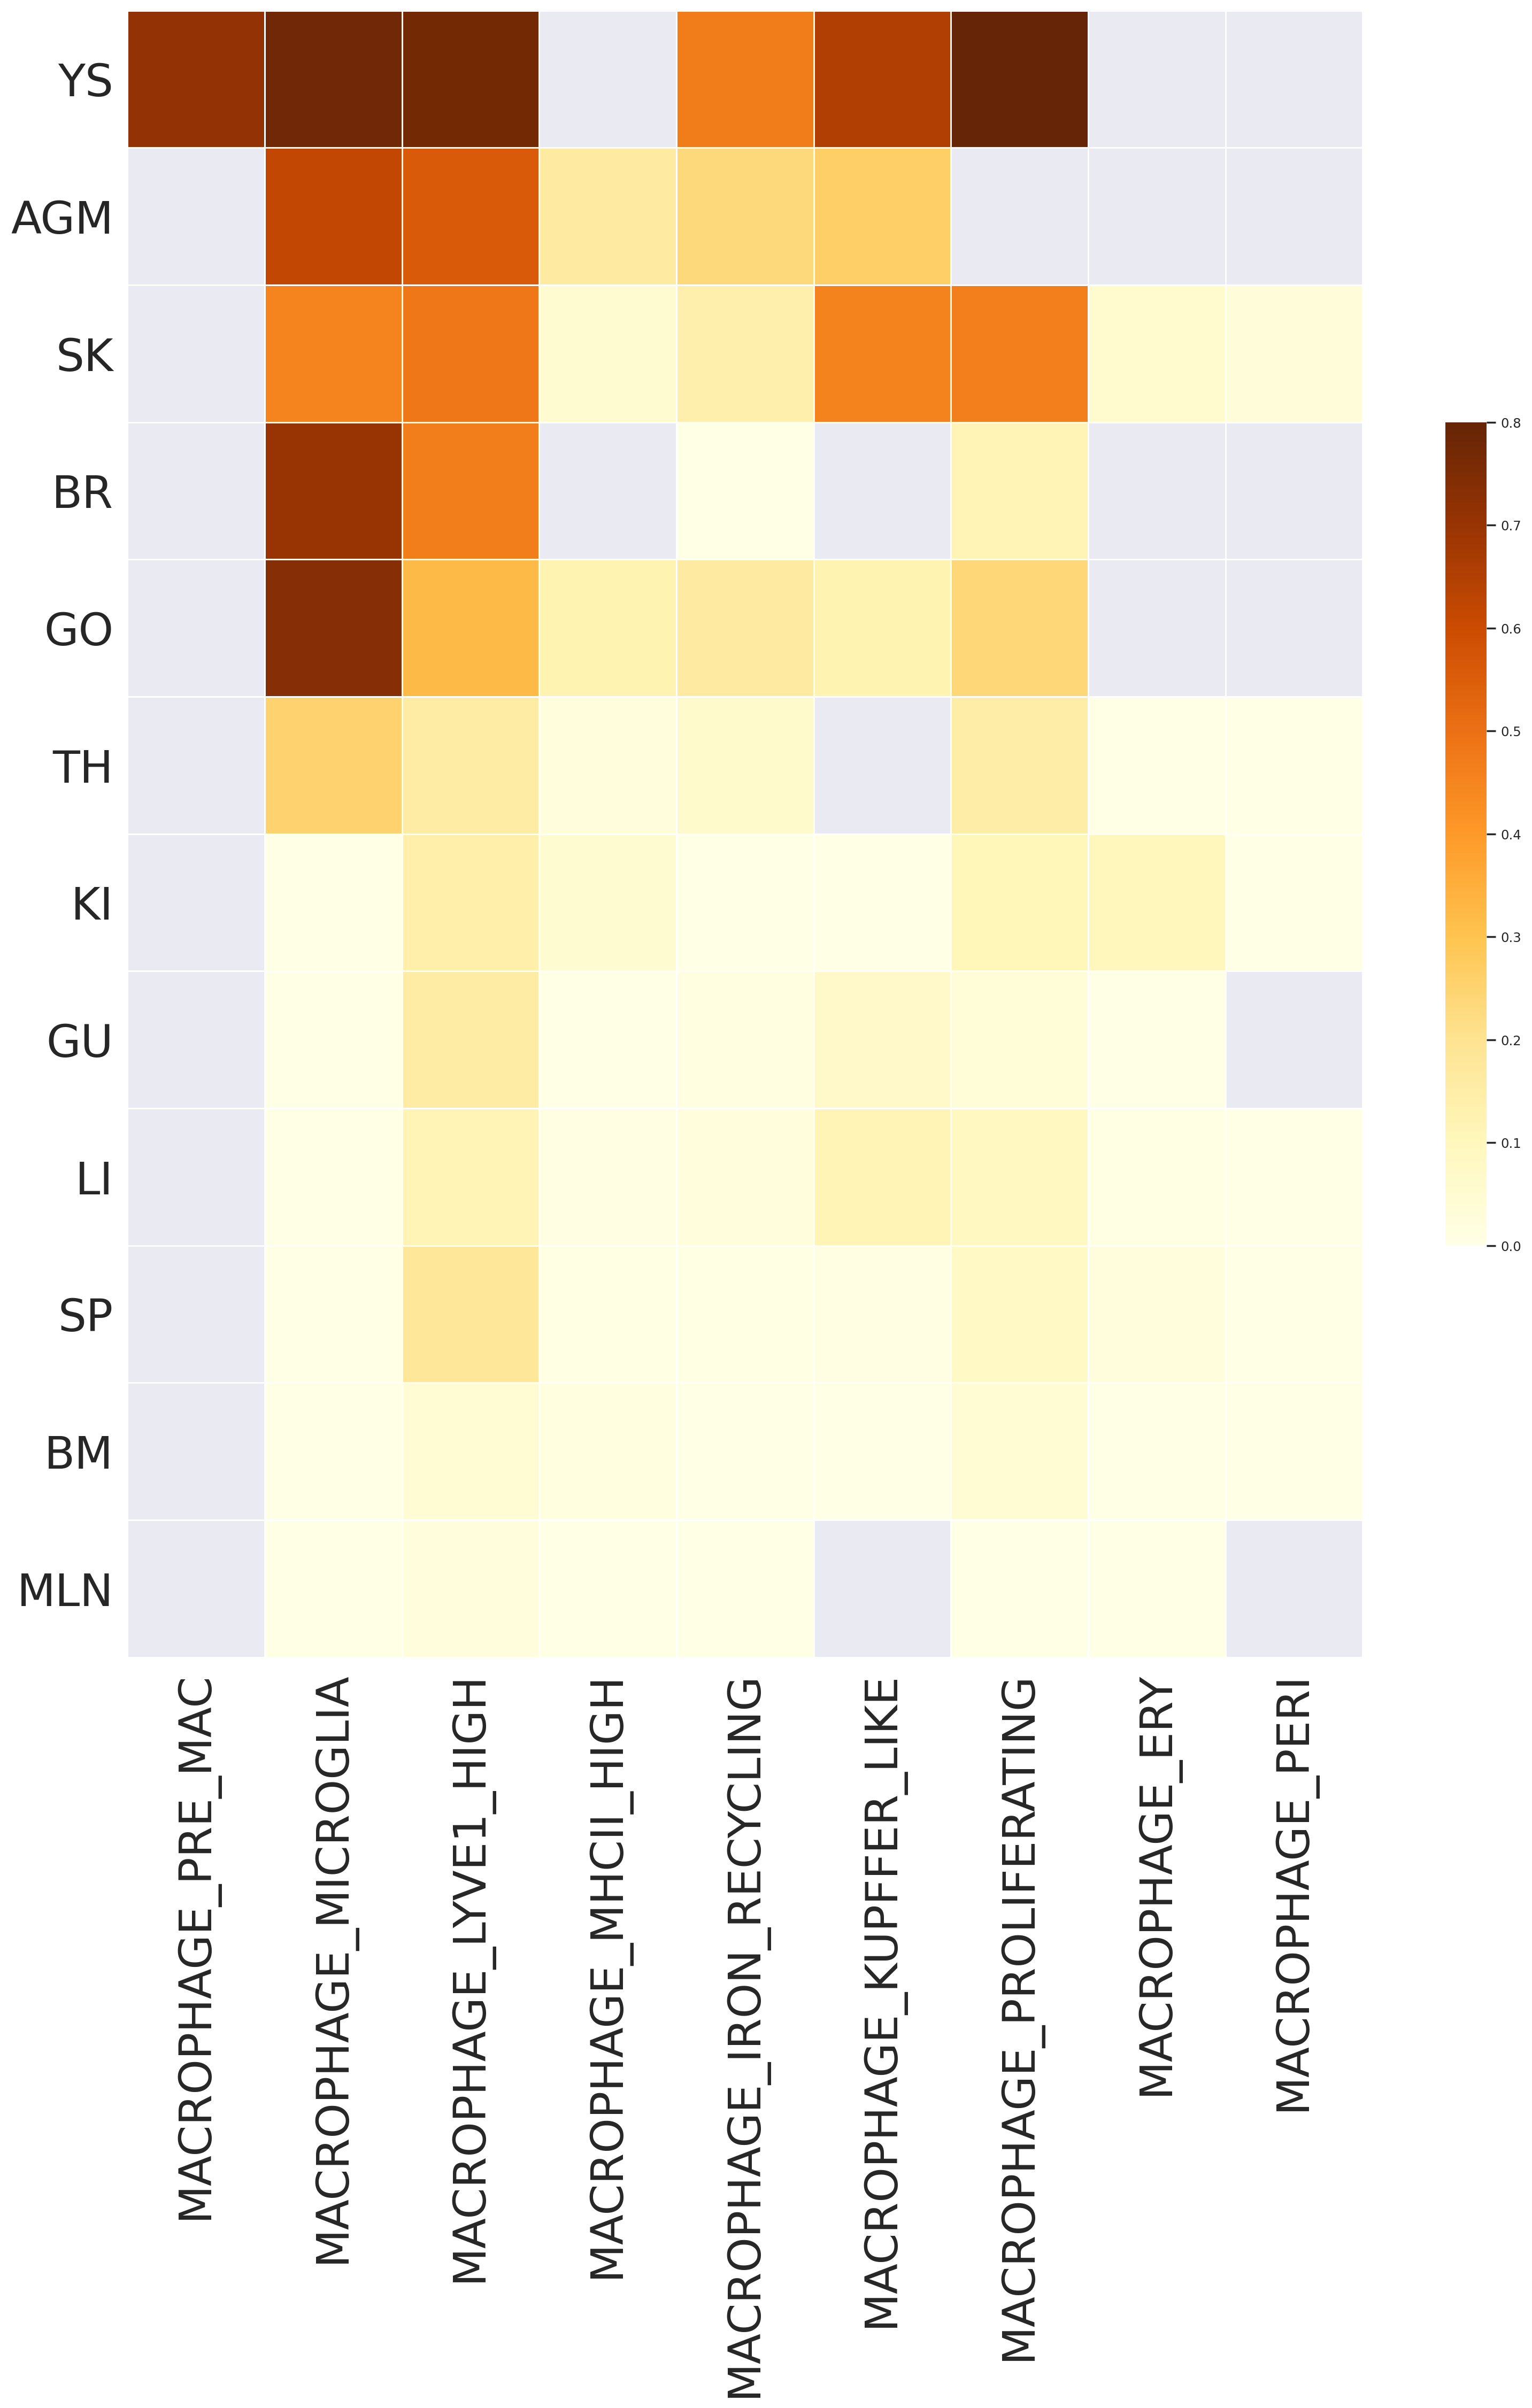

In [244]:
import seaborn as sns; sns.set(color_codes=True)
save_path = './'
pal = sns.color_palette("YlOrBr", as_cmap=True)#pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,20))
sns.set(font_scale=0.8)
g = sns.heatmap(prop_df, cmap=pal, vmin=0, vmax=0.8, linewidths=1, center=0.4, square=True, cbar_kws={"shrink": 0.5})
plt.yticks(rotation=0,fontsize = 30)
plt.xticks(rotation=90,fontsize = 30)
# plt.xlabel("Original labels")
# plt.ylabel("Predicted labels")
plt.savefig("./prop_enrich.pdf",bbox_inches='tight')
prop_df.to_csv("./prop_enrich.csv")

In [199]:
temp_df

organ                       LVL3               LVL5  counts prop
10    BM             MACROPHAGE_ERY                MAC      38   na
11    BM  MACROPHAGE_IRON_RECYCLING                MAC     127   na
12    BM    MACROPHAGE_KUPFFER_LIKE                MAC       5   na
13    BM      MACROPHAGE_LYVE1_HIGH                MAC    1439   na
14    BM      MACROPHAGE_LYVE1_HIGH  MACROPHAGE_TLF_hi      72   na
15    BM      MACROPHAGE_MHCII_HIGH                MAC     115   na
16    BM      MACROPHAGE_MHCII_HIGH  MACROPHAGE_TLF_hi       2   na
17    BM       MACROPHAGE_MICROGLIA                MAC       3   na
18    BM       MACROPHAGE_MICROGLIA  MACROPHAGE_TLF_hi       1   na
19    BM            MACROPHAGE_PERI                MAC       1   na
20    BM   MACROPHAGE_PROLIFERATING                MAC      65   na
21    BM   MACROPHAGE_PROLIFERATING  MACROPHAGE_TLF_hi       3   na

In [194]:
prop_df.loc[prop_df.index.isin([organ]),lvl] = 

YS    NaN
Name: MACROPHAGE_PROLIFERATING, dtype: object

<ipython-input-168-5ad73fc185b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['prop'] = 'na'
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
temp_df

In [172]:
temp_df.loc[temp_df.index.isin([lvl]),'prop']

Series([], Name: prop, dtype: object)

In [171]:
temp_df.loc[temp_df['LVL3'].isin([lvl]),'counts'].iloc[1]/np.sum(temp_df.loc[temp_df['LVL3'].isin([lvl]),'counts'])

0.847331093691676

In [169]:
temp_df

organ                       LVL3               LVL5  counts prop
128    YS  MACROPHAGE_IRON_RECYCLING                MAC    7562   na
129    YS  MACROPHAGE_IRON_RECYCLING  MACROPHAGE_TLF_hi   15384   na
130    YS    MACROPHAGE_KUPFFER_LIKE                MAC    1914   na
131    YS    MACROPHAGE_KUPFFER_LIKE  MACROPHAGE_TLF_hi    5810   na
132    YS      MACROPHAGE_LYVE1_HIGH                MAC    1937   na
133    YS      MACROPHAGE_LYVE1_HIGH  MACROPHAGE_TLF_hi    6448   na
134    YS       MACROPHAGE_MICROGLIA                MAC     381   na
135    YS       MACROPHAGE_MICROGLIA  MACROPHAGE_TLF_hi     232   na
136    YS         MACROPHAGE_PRE_MAC                MAC      20   na
137    YS         MACROPHAGE_PRE_MAC  MACROPHAGE_TLF_hi       9   na
138    YS   MACROPHAGE_PROLIFERATING                MAC     818   na
139    YS   MACROPHAGE_PROLIFERATING  MACROPHAGE_TLF_hi    4540   na

In [ ]:
ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
for organ in ranker['organ'].unique():
    rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])

In [ ]:
ranker = data.groupby(['organ','LVL5']).apply(len).reset_index()
rank_prop = pd.DataFrame(index = ranker['organ'].unique(),columns = ['prop'])
for organ in ranker['organ'].unique():
    rank_prop.loc[rank_prop.index.isin([organ]),'prop'] =  ranker.loc[ranker['organ'].isin([organ]),0].iloc[1]/ np.sum(ranker.loc[ranker['organ'].isin([organ]),0])
rank_prop = rank_prop.sort_values('prop',ascending = False)
data['organ'] = data['organ'].cat.reorder_categories(list(rank_prop.index))
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or weight: {a

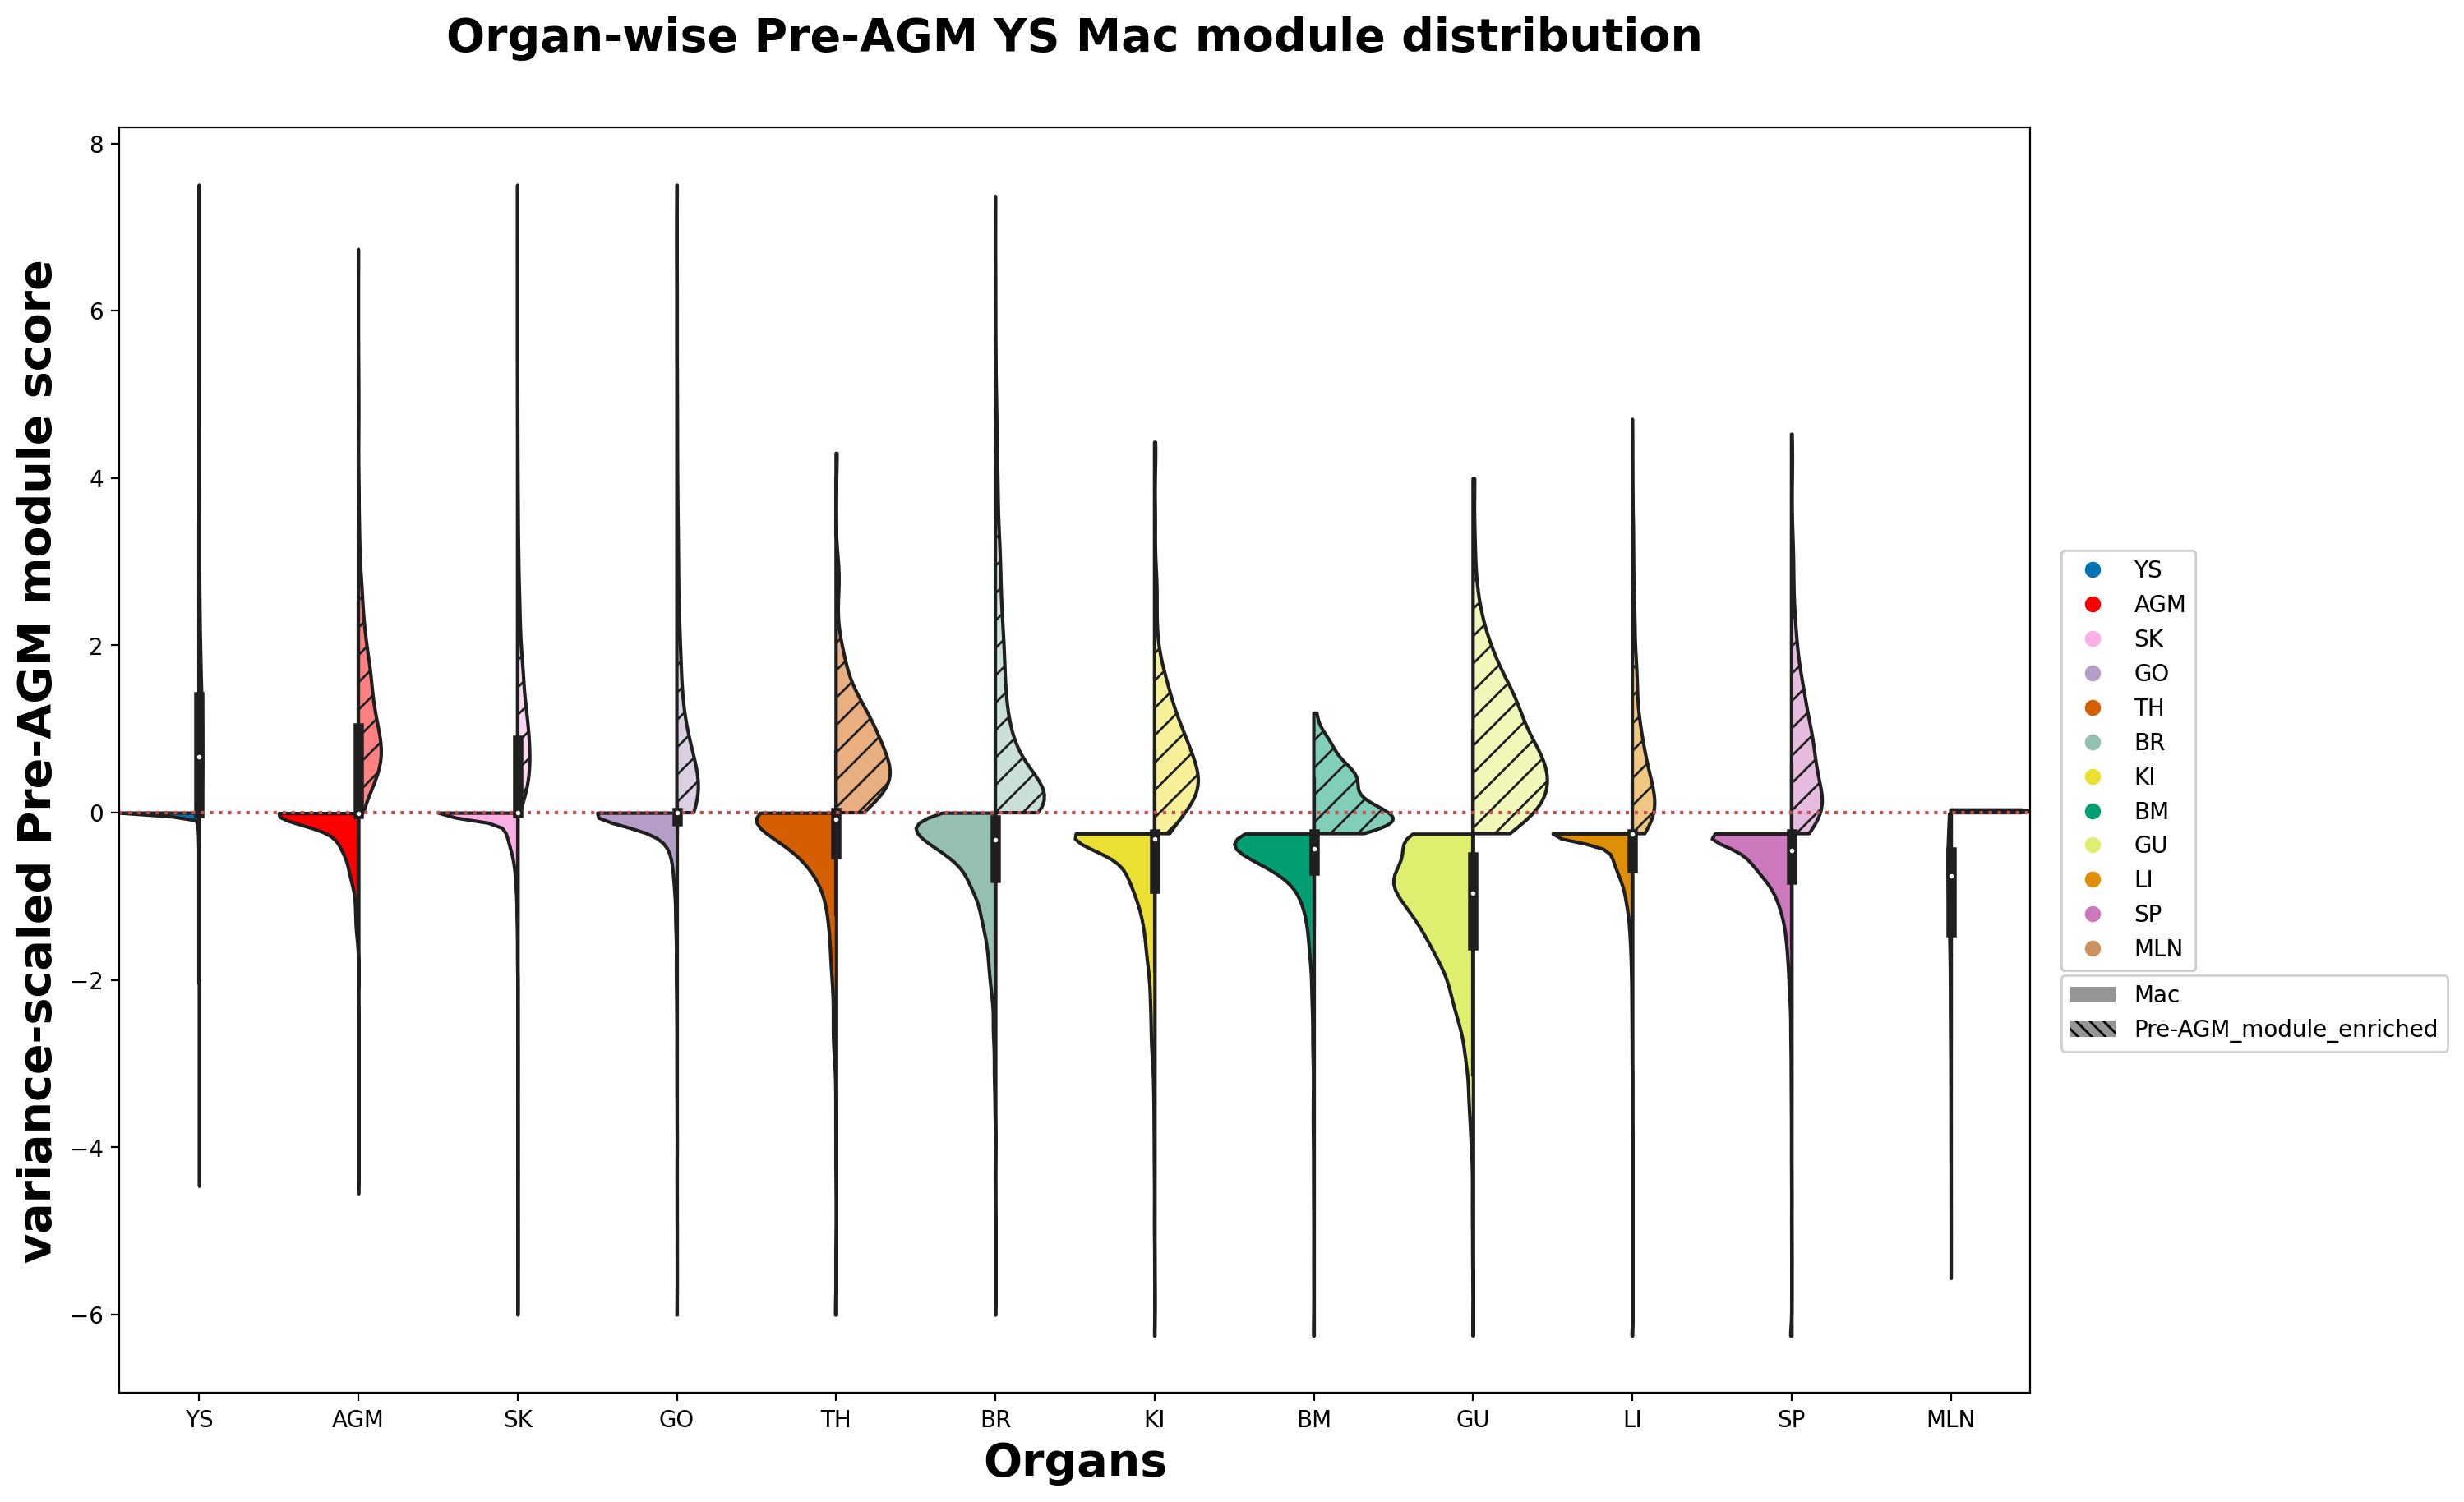

In [390]:
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.patches as mpatches

plt.rcdefaults()
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(15,10))

data = data
x = 'organ'
y = 'scaled_pre_agm_mac_score'
split = 'LVL5'
save_name = './v5_multi_color_ordered_Violin_organ_wise_tlf_distribution.pdf'
col_dict = dict([(key, col_dict[key]) for key in rank_prop.index if key in col_dict])
jitter = False
use_custom_color_dict = True

if use_custom_color_dict == False:
    sns.set_palette(palette = sns.color_palette())
    ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1, split_palette=True,cut=0,)#palette = []
    # add hatched legend
    circ1 = mpatches.Patch( facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),alpha=0.8,label='Mac')
    circ2 = mpatches.Patch( facecolor=(1.0, 0.4980392156862745, 0.054901960784313725),alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')
else:
    ax = sns.violinplot(x=x, y=y,hue = split, data=data,split= True,size=5,width = 1, split_palette=True,cut=0, palette=['.2', '.5'])#palette = []
    if jitter == True:
        ax = sns.stripplot(x=x, y=y, data=data_striplot,jitter=0.2, zorder=1,alpha=.5,size=1,color = 'grey')#,palette =col_dict ) #palette =col_dict 
    colors = list(col_dict.values()) + list(col_dict.values())
    handles = []
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
        violin.set_facecolor(rgb)
        handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))#hatch=r'\\\\')
        # set marker colors
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in col_dict.values()]
        legend2 = plt.legend(markers, color_key.keys(), numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.5))
        ax.add_artist(legend2)
        plt.setp(legend2.get_title())#,fontsize='small'
        # add hatched legend
        circ1 = mpatches.Patch( facecolor='#808080',alpha=0.8,label='Mac')
        circ2 = mpatches.Patch( facecolor='#808080',alpha=0.8,hatch=r'\\\\',label='Pre-AGM_module_enriched')

for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
    if i % 2:
        violin.set_hatch("//")
        
# red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
#legend1 = plt.legend(handles=[tuple(handles[::2]), tuple(handles[1::2]),red_line], labels=data["LVL5"].cat.categories.to_list(),title="Pre-AGM mac module enriched", handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},bbox_to_anchor=(1.21, 1))

legend3 = plt.legend(handles=[circ1,circ2], numpoints=1,loc='center left', bbox_to_anchor=(1.01, 0.3))
#ax.add_artist(legend1)
ax.add_artist(legend3)

plt.axhline(y = 0, color = 'r', linestyle = ':')#np.mean(adata_macs.obs['scaled_pre_agm_mac_score'])#plt.axhline(y = np.mean(adata_macs.obs['scaled_pre_agm_mac_score']), color = 'r', linestyle = ':')
plt.title("Organ-wise Pre-AGM YS Mac module distribution",fontsize = 20,y=1.05,fontweight='bold')
plt.ylabel("variance-scaled Pre-AGM module score",fontsize = 20,fontweight='bold')
plt.xlabel("Organs",fontsize = 20,fontweight='bold')
plt.savefig((save_name),dpi=300,bbox_inches='tight')
plt.show()